---
title: SpatioTemporal Field - PR - Stationary + GP
subject: AEMET PR
short_title: 1 - Laplacian Inference
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CSIC
      - UCM
      - IGEO
    orcid: 0000-0002-6739-0053
    email: juanjohn@ucm.es
license: CC-BY-4.0
keywords: notation
---

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" # first gpu
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'

import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
import multiprocessing

num_devices = multiprocessing.cpu_count()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(num_devices)
jax.config.update("jax_enable_x64", True)

In [2]:
import autoroot
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray
import arviz as az

from st_evt.viz import plot_histogram, plot_density, plot_spain
from st_evt.utils import load_spain_provinces, load_spain_communities
from omegaconf import OmegaConf

import jax
import jax.random as jrandom
import jax.numpy as jnp
import pandas as pd

rng_key = jrandom.PRNGKey(123)

from numpyro.infer import Predictive
import arviz as az

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import xarray as xr
import regionmask

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)

from loguru import logger

# num_devices = 5
# numpyro.set_host_device_count(num_devices)


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [4]:
# load dataset
dataset_path = autoroot.root.joinpath("data/ml_ready/aemet/pr_stations_bm_fall.zarr")

# PARAMETERS
variables = ["pr"]
covariates = ["gmst"]
SPATIAL_DIM_NAME = "station_id"
SPATIAL_COORDS_DIM_NAME = "spherical"
OUTPUT_DIM_NAME = "variable"

# LOAD DATA
with xr.open_dataset(dataset_path, engine="zarr") as f:
    ds_bm = f.load()
    ds_bm = ds_bm.swap_dims({"gmst": "time"})
    ds_bm = ds_bm.reset_coords(covariates)
    spain_regionmask = load_spain_communities(overlap=True)
    mask = spain_regionmask.mask_3D(ds_bm)
    vlc_region = mask.where(mask.names == 'Comunitat Valenciana', drop=True).squeeze()

    # drop extras
    logger.info(f"Dropping Non VLC...")
    # temp_covs = ds_bm[covariates]
    # ds_bm = ds_bm[variables].where(mask, drop=True)
    temp_covs = ds_bm[covariates]
    ds_bm = ds_bm[variables].where(vlc_region, drop=True)
    ds_bm = xr.merge([ds_bm, temp_covs])

# Create Data Array
# ds_bm = ds_bm[variables].to_dataarray(dim="variable")
# Rearrange
# ds_bm = ds_bm.transpose(covariate, spatial_dim_name, "variable")
ds_bm

2025-01-09 19:55:22.978 | INFO     | __main__:<module>:21 - Dropping Non VLC...


<xarray.Dataset> Size: 48kB
Dimensions:         (time: 59, station_id: 100)
Coordinates:
    alt             (station_id) float32 400B 93.0 1.0 1.0 ... 998.0 1.22e+03
    lat             (station_id) float32 400B 37.97 37.99 38.03 ... 40.62 40.5
    lon             (station_id) float32 400B -0.7901 -0.7196 ... -0.1021 -0.188
    red_feten_mask  (station_id) uint8 100B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
  * station_id      (station_id) <U5 2kB '7037A' '7038' '7041' ... '9562' '9563'
    station_name    (station_id) <U50 20kB 'san miguel de salinas (g.esco-lar...
  * time            (time) int64 472B 1961 1962 1963 1964 ... 2017 2018 2019
    region          int64 8B 10
    abbrevs         <U3 12B 'r10'
    names           <U26 104B 'Comunitat Valenciana'
Data variables:
    pr              (time, station_id) float32 24kB 6.5 2.9 15.2 ... 56.6 52.0
    gmst            (time) float64 472B 0.2447 0.1987 0.1827 ... 1.173 1.139

## Features

### Coordinate Transformation

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from st_evt._src.features.spatial import Geodetic2Cartesian

spatial_coords_names = ["lon", "lat", "alt"]

# Select Coordinates
s_coords = ds_bm[spatial_coords_names].to_dataframe()[spatial_coords_names].values

# initialize transformer
spatial_transformer = Pipeline(
    steps=[
        # ("cartesian", Geodetic2Cartesian()),
        ("standardize", StandardScaler())
    ]
)

# fit transformer
spatial_transformer.fit(s_coords)

# apply transformer
s_coords_transformed = spatial_transformer.transform(s_coords)

In [6]:


ds_bm["coords_norm"] = ((SPATIAL_DIM_NAME, SPATIAL_COORDS_DIM_NAME), s_coords_transformed)
ds_bm = ds_bm.assign_coords({SPATIAL_COORDS_DIM_NAME:spatial_coords_names})
ds_bm

<xarray.Dataset> Size: 49kB
Dimensions:         (time: 59, station_id: 100, spherical: 3)
Coordinates:
    alt             (station_id) float32 400B 93.0 1.0 1.0 ... 998.0 1.22e+03
    lat             (station_id) float32 400B 37.97 37.99 38.03 ... 40.62 40.5
    lon             (station_id) float32 400B -0.7901 -0.7196 ... -0.1021 -0.188
    red_feten_mask  (station_id) uint8 100B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
  * station_id      (station_id) <U5 2kB '7037A' '7038' '7041' ... '9562' '9563'
    station_name    (station_id) <U50 20kB 'san miguel de salinas (g.esco-lar...
  * time            (time) int64 472B 1961 1962 1963 1964 ... 2017 2018 2019
    region          int64 8B 10
    abbrevs         <U3 12B 'r10'
    names           <U26 104B 'Comunitat Valenciana'
  * spherical       (spherical) <U3 36B 'lon' 'lat' 'alt'
Data variables:
    pr              (time, station_id) float32 24kB 6.5 2.9 15.2 ... 56.6 52.0
    gmst            (time) float64 472B 0.2447 0.1987 0.1827 ... 1.173 1.139
    coords_norm     (station_id, spherical) float32 1kB -0.7467 -1.842 ... 3.018

In [7]:
from sklearn.preprocessing import StandardScaler


# Select Coordinates
y_df = ds_bm[variables].to_dataframe()[variables]

# initialize transformer
variable_transformer = Pipeline(
    steps=[
        ("standardize", StandardScaler(with_mean=False))
    ]
)

# fit transformer
variable_transformer.fit(y_df.values)

# apply transformer

y_values_transformed = variable_transformer.transform(y_df.values)

variables_norm = [f"{iname}_norm" for iname in variables]

y_df[variables_norm] = y_values_transformed

for ivariable in variables_norm:
    ds_bm[ivariable] = y_df.to_xarray()[ivariable]


ds_bm

<xarray.Dataset> Size: 72kB
Dimensions:         (time: 59, station_id: 100, spherical: 3)
Coordinates:
    alt             (station_id) float32 400B 93.0 1.0 1.0 ... 998.0 1.22e+03
    lat             (station_id) float32 400B 37.97 37.99 38.03 ... 40.62 40.5
    lon             (station_id) float32 400B -0.7901 -0.7196 ... -0.1021 -0.188
    red_feten_mask  (station_id) uint8 100B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
  * station_id      (station_id) object 800B '7037A' '7038' ... '9562' '9563'
    station_name    (station_id) <U50 20kB 'san miguel de salinas (g.esco-lar...
  * time            (time) int64 472B 1961 1962 1963 1964 ... 2017 2018 2019
    region          int64 8B 10
    abbrevs         <U3 12B 'r10'
    names           <U26 104B 'Comunitat Valenciana'
  * spherical       (spherical) <U3 36B 'lon' 'lat' 'alt'
Data variables:
    pr              (time, station_id) float32 24kB 6.5 2.9 15.2 ... 56.6 52.0
    gmst            (time) float64 472B 0.2447 0.1987 0.1827 ... 1.173 1.139
    coords_norm     (station_id, spherical) float32 1kB -0.7467 -1.842 ... 3.018
    pr_norm         (time, station_id) float32 24kB 0.1273 0.05677 ... 1.018

## Dataset Split



### Training Data

In this experiment, we are only going to use the `red_feten` stations. 
Supposedly, these are stations which have clean data.

In [77]:
testing = True

In [78]:
# Randomly select 25 station_ids


np.random.seed(42)  # For reproducibility
num_train = 25
if testing:
    selected_station_ids = np.random.choice(ds_bm.station_id.values, size=num_train, replace=False)
else:
    selected_station_ids = ds_bm.where(ds_bm.red_feten_mask == 1, drop=True).station_id

In [79]:
# VARIABLES
ds_bm_train = ds_bm[variables]
    
# Create Data Array
ds_bm_variables_train = ds_bm_train.to_dataarray(dim="variable")
# Rearrange
ds_bm_variables_train = ds_bm_variables_train.transpose("time", SPATIAL_DIM_NAME, "variable")

y_train = ds_bm_variables_train.values

# COVARIATE
ds_bm_covariates_train = ds_bm[covariates]
ds_bm_covariates_train = ds_bm_covariates_train.to_dataarray(dim="covariate").transpose("time", "covariate")
x_train = ds_bm_covariates_train.values

# COORDINATES
ds_bm_coords_train = ds_bm["coords_norm"]

# Rearrange
ds_bm_coords_train = ds_bm_coords_train.transpose(SPATIAL_DIM_NAME, "spherical")
s_train = ds_bm_coords_train.values.astype(np.float64)

print(s_train.shape, x_train.shape, y_train.shape)

(100, 3) (59, 1) (59, 100, 1)


### Test Data

For testing, we are going to use the non-`red_feten` stations. 
Supposedly, these are stations which we have observations for but they may (or may not) be the cleanest.

In [80]:
# VARIABLES
ds_bm_variables_test = ds_bm[variables]#.where(ds_bm.red_feten_mask == 1, drop=True,)
    
# 
# Create Data Array
ds_bm_variables_test = ds_bm_variables_test.to_dataarray(dim="variable")
# Rearrange
ds_bm_variables_test = ds_bm_variables_test.transpose("time", SPATIAL_DIM_NAME, "variable")

y_test = ds_bm_variables_test.values

# COVARIATE
ds_bm_covariates_test = ds_bm[covariates]
ds_bm_covariates_test = ds_bm_covariates_test.to_dataarray(dim="covariate").transpose("time", "covariate")
x_test = ds_bm_covariates_test.values

# COORDINATES
ds_bm_coords_test = ds_bm["coords_norm"] #.where(ds_bm.red_feten_mask == 1, drop=True,)
    
# 
# Rearrange
ds_bm_coords_test = ds_bm_coords_test.transpose(SPATIAL_DIM_NAME, "spherical")
s_test = ds_bm_coords_test.values.astype(np.float64)

print(s_test.shape, x_test.shape, y_test.shape)

(100, 3) (59, 1) (59, 100, 1)


### Prediction Data

For predictions, we will predict for all stations but for the future.

In [81]:
y_pred = y_test.copy()

x_pred = jnp.linspace(0.0, 2.5, 50)[:, None]

s_pred = s_test.copy()

print(s_pred.shape, x_pred.shape, y_pred.shape)

(100, 3) (50, 1) (59, 100, 1)


## Model

In [82]:
from vgp import LocSTGEVDLikelihood, LinearModel, ARDRBFKernel, ARDRBFCholeskyKernel, SpatialVariationalGP, GWR
num_input_dims = 3
num_output_dims = 1
num_param_dims = 2
num_cov_dims = 1

# NAMES
LOG_LOC_INIT = jnp.log(jnp.mean(y_train))
LOG_SCALE_INIT = jnp.log(jnp.std(y_train))



def build_model(s):
    
    location_mean = LinearModel.init_from_numpyro_priors(
        name="location_mean",
        num_input_dims=num_input_dims,
        num_output_dims=num_output_dims,
        slope_prior=dist.Normal(0.0, 1.0),
        intercept_prior=dist.LogNormal(LOG_LOC_INIT, 1.0),
        input_dim_name=SPATIAL_COORDS_DIM_NAME,
        output_dim_name="variable",
        batch_dim_name=SPATIAL_DIM_NAME
    )
    
    
    # INITIALIZE KERNEL MODEL
    location_kernel_model = ARDRBFCholeskyKernel.init_from_numpyro_priors(
        name="location_kernel",
        num_input_dims=num_input_dims,
        input_dim_name=SPATIAL_COORDS_DIM_NAME,
    )

    
    # INTIALIZE INTERCEPT GP MODEL
    location_gp_model = SpatialVariationalGP(
        name="location",
        s=s,
        num_latent_dims=num_output_dims,
        jitter=1e-5,
        mean=location_mean,
        kernel=location_kernel_model,
        sample_dim_name=SPATIAL_DIM_NAME,
        latent_dim_name="variable",
        link_function=lambda x: jax.nn.softplus(x)
    )
    
    scale_mean = LinearModel.init_from_numpyro_priors(
        name="scale_mean",
        num_input_dims=num_input_dims,
        num_output_dims=num_output_dims,
        slope_prior=dist.Normal(0.0, 1.0),
        intercept_prior=dist.LogNormal(LOG_SCALE_INIT, 1.0),
        # intercept_prior=dist.HalfNormal(SCALE_INIT),
        input_dim_name=SPATIAL_COORDS_DIM_NAME,
        output_dim_name="variable",
        batch_dim_name=SPATIAL_DIM_NAME
    )
    
    
    # INITIALIZE KERNEL MODEL
    scale_kernel_model = ARDRBFCholeskyKernel.init_from_numpyro_priors(
        name="scale_kernel",
        num_input_dims=num_input_dims,
        input_dim_name=SPATIAL_COORDS_DIM_NAME,
    )

    
    # INTIALIZE INTERCEPT GP MODEL
    scale_gp_model = SpatialVariationalGP(
        name="scale",
        s=s,
        num_latent_dims=num_output_dims,
        jitter=1e-5,
        mean=scale_mean,
        kernel=scale_kernel_model,
        sample_dim_name=SPATIAL_DIM_NAME,
        latent_dim_name="variable",
        link_function=lambda x: jax.nn.softplus(x)
    )
    concentration_prior = dist.TruncatedNormal(loc=0.3, scale=0.1, low=1e-5, high=1.0)
    
    model = LocSTGEVDLikelihood(
        location=location_gp_model,
        scale=scale_gp_model,
        concentration_prior=concentration_prior,
        time_dim_name="time", 
        spatial_dim_name=SPATIAL_DIM_NAME
        )
        
    return model


def numpyro_model(s, x, y=None, train=False, time_batchsize=None):
    model = build_model(s_train)
    return model(s=s, t=x, y=y, train=train)

In [83]:
with numpyro.handlers.seed(rng_seed=42):
    # Test
    model = build_model(s=s_train)
    print(model.variables)
    print(model.dimensions)
with numpyro.handlers.seed(rng_seed=42):
    # Test
    mu_pred = numpyro_model(s=s_pred, x=x_pred, y=None, train=False)
    print("OUT:", mu_pred.shape)
    mu_train = numpyro_model(s=s_train, x=x_train, y=None, time_batchsize=16, train=True)
    print(mu_train.shape)
    mu_train = numpyro_model(s=s_train, x=x_train, y=None, time_batchsize=None, train=True)
    print(mu_train.shape)

['location_field_cond', 'location_field', 'location', 'location_noise', 'location_mean_intercept', 'location_mean_slope', 'location_mean', 'location_kernel_variance', 'location_kernel_scale_diagonal', 'location_kernel_scale_offdiagonal', 'scale_field_cond', 'scale_field', 'scale', 'scale_noise', 'scale_mean_intercept', 'scale_mean_slope', 'scale_mean', 'scale_kernel_variance', 'scale_kernel_scale_diagonal', 'scale_kernel_scale_offdiagonal', 'concentration', 'obs']
{'location_field_cond': ['variable', 'station_id'], 'location_field': ['variable', 'station_id'], 'location': ['station_id', 'variable'], 'location_noise': [], 'location_mean_intercept': ['variable'], 'location_mean_slope': ['spherical', 'variable'], 'location_mean': ['station_id', 'variable'], 'location_kernel_variance': [], 'location_kernel_scale_diagonal': ['spherical'], 'location_kernel_scale_offdiagonal': ['spherical'], 'scale_field_cond': ['variable', 'station_id'], 'scale_field': ['variable', 'station_id'], 'scale': ['

In [84]:
# import cartopy.crs as ccrs
# fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson()))

# # Convert coordinates to GeoDataFrame
# geometry = [Point(lon, lat) for lon, lat in zip(ds_bm_variables_train.lon, ds_bm_variables_train.lat)]
# gdf_points = gpd.GeoDataFrame(geometry=geometry)

# spain_regionmask[['Valencia/València']].plot(label_multipolygon="largest", ax=ax)

# pts = gdf_points.plot(ax=ax, c=np.asarray(mu_train[0,...,0]), cmap="Blues", markersize=50)

# plt.title('Red Feten Stations')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid(True, which="both", linestyle='--', linewidth='0.5', color='gray')
# # fig.set(dpi=100)
# plt.show()

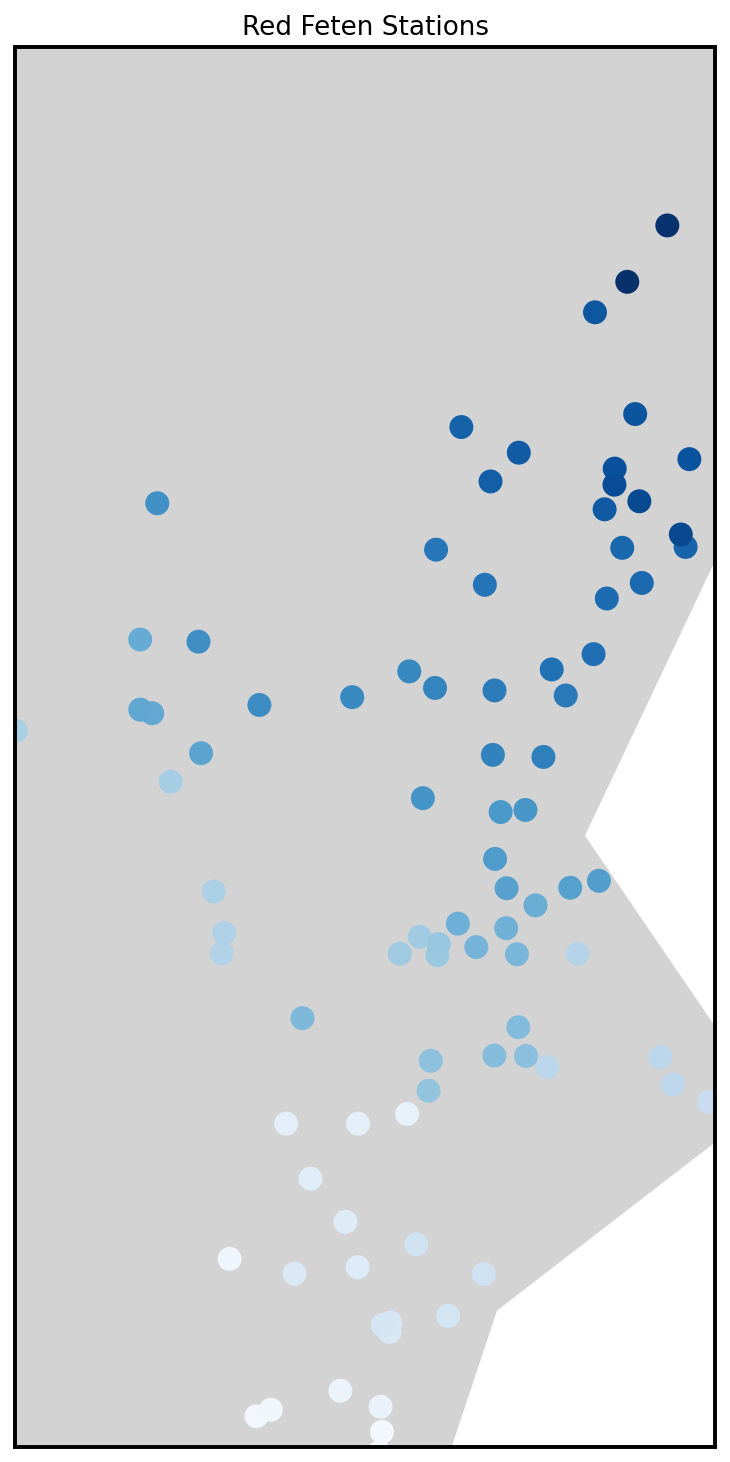

In [85]:
import cartopy.crs as ccrs
from shapely.geometry import Point
import geopandas as gpd

COUNTRIES_GEOJSON = "https://raw.githubusercontent.com/johan/world.geo.json/refs/heads/master/countries.geo.json"

# Convert coordinates to GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(ds_bm_variables_train.lon, ds_bm_variables_train.lat)]
gdf_points = gpd.GeoDataFrame(geometry=geometry)

# Load Spain map
world = gpd.read_file(COUNTRIES_GEOJSON)
spain = world[world.name == "Spain"]

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
spain.plot(ax=ax, color='lightgrey')
pts = gdf_points.plot(ax=ax, c=np.asarray(mu_train[0,...,0]), cmap="Blues", markersize=100)

extent = [-1.5, 0.0, 38, 41] 

ax.set_extent(extent)
plt.title('Red Feten Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, which="both", linestyle='--', linewidth='0.5', color='gray')
fig.set(dpi=75)
plt.show()

### Prior Predictions

In [86]:
from numpyro.infer import Predictive

rng_key, rng_key_prior = jrandom.split(rng_key)
return_sites = model.variables # ["location"]
prior_predictive = Predictive(numpyro_model, return_sites=return_sites, num_samples=1_000)

prior_samples = prior_predictive(rng_key_prior, s=s_train, x=x_train, y=None, train=True)

In [87]:
ds_bm[covariates]

<xarray.Dataset> Size: 1kB
Dimensions:  (time: 59)
Coordinates:
  * time     (time) int64 472B 1961 1962 1963 1964 1965 ... 2016 2017 2018 2019
    region   int64 8B 10
    abbrevs  <U3 12B 'r10'
    names    <U26 104B 'Comunitat Valenciana'
Data variables:
    gmst     (time) float64 472B 0.2447 0.1987 0.1827 ... 1.151 1.173 1.139

In [88]:
az_ds_prior = az.from_numpyro(
    prior=prior_samples,
    dims=model.dimensions,
    
)

# correct coordinates
az_ds_prior = az_ds_prior.assign_coords({"variable":  variables})
az_ds_prior = az_ds_prior.assign_coords({SPATIAL_DIM_NAME:  ds_bm_train[SPATIAL_DIM_NAME]})
az_ds_prior = az_ds_prior.assign_coords({SPATIAL_COORDS_DIM_NAME:  ds_bm_coords_train[SPATIAL_COORDS_DIM_NAME]})
az_ds_prior = az_ds_prior.assign_coords({"time":  ds_bm_variables_train.time})
az_ds_prior.prior = xr.merge([az_ds_prior.prior, ds_bm[covariates]])

az_ds_prior

Inference data with groups:
	> prior

In [89]:
idata = az.extract(az_ds_prior, group="prior", num_samples=1_000)
idata

<xarray.Dataset> Size: 52MB
Dimensions:                            (sample: 1000, station_id: 100,
                                        variable: 1, spherical: 3, time: 59)
Coordinates: (12/15)
  * variable                           (variable) <U2 8B 'pr'
    alt                                (station_id) float32 400B 93.0 ... 1.2...
    lat                                (station_id) float32 400B 37.97 ... 40.5
    lon                                (station_id) float32 400B -0.7901 ... ...
    red_feten_mask                     (station_id) uint8 100B 0 0 0 0 ... 0 0 0
  * station_id                         (station_id) object 800B '7037A' ... '...
    ...                                 ...
    names                              <U26 104B 'Comunitat Valenciana'
  * spherical                          (spherical) <U3 36B 'lon' 'lat' 'alt'
  * time                               (time) int64 472B 1961 1962 ... 2018 2019
  * sample                             (sample) object 8kB MultiIndex
  * chain                              (sample) int64 8kB 0 0 0 0 0 ... 0 0 0 0
  * draw                               (sample) int64 8kB 23 159 637 ... 213 672
Data variables: (12/21)
    concentration                      (sample) float64 8kB 0.3016 ... 0.4255
    location                           (station_id, variable, sample) float64 800kB ...
    location_field_cond                (variable, station_id, sample) float64 800kB ...
    location_kernel_scale_diagonal     (spherical, sample) float64 24kB 0.413...
    location_kernel_scale_offdiagonal  (spherical, sample) float64 24kB 0.214...
    location_kernel_variance           (sample) float64 8kB 5.006 ... 0.7674
    ...                                 ...
    scale_kernel_variance              (sample) float64 8kB 0.5539 ... 2.969
    scale_mean                         (station_id, variable, sample) float64 800kB ...
    scale_mean_intercept               (variable, sample) float64 8kB 120.8 ....
    scale_mean_slope                   (spherical, variable, sample) float64 24kB ...
    scale_noise                        (sample) float64 8kB 0.4607 ... 0.7123
    gmst                               (time) float64 472B 0.2447 ... 1.139
Attributes:
    created_at:                 2025-01-09T19:08:09.486891+00:00
    arviz_version:              0.20.0
    inference_library:          numpyro
    inference_library_version:  0.16.1

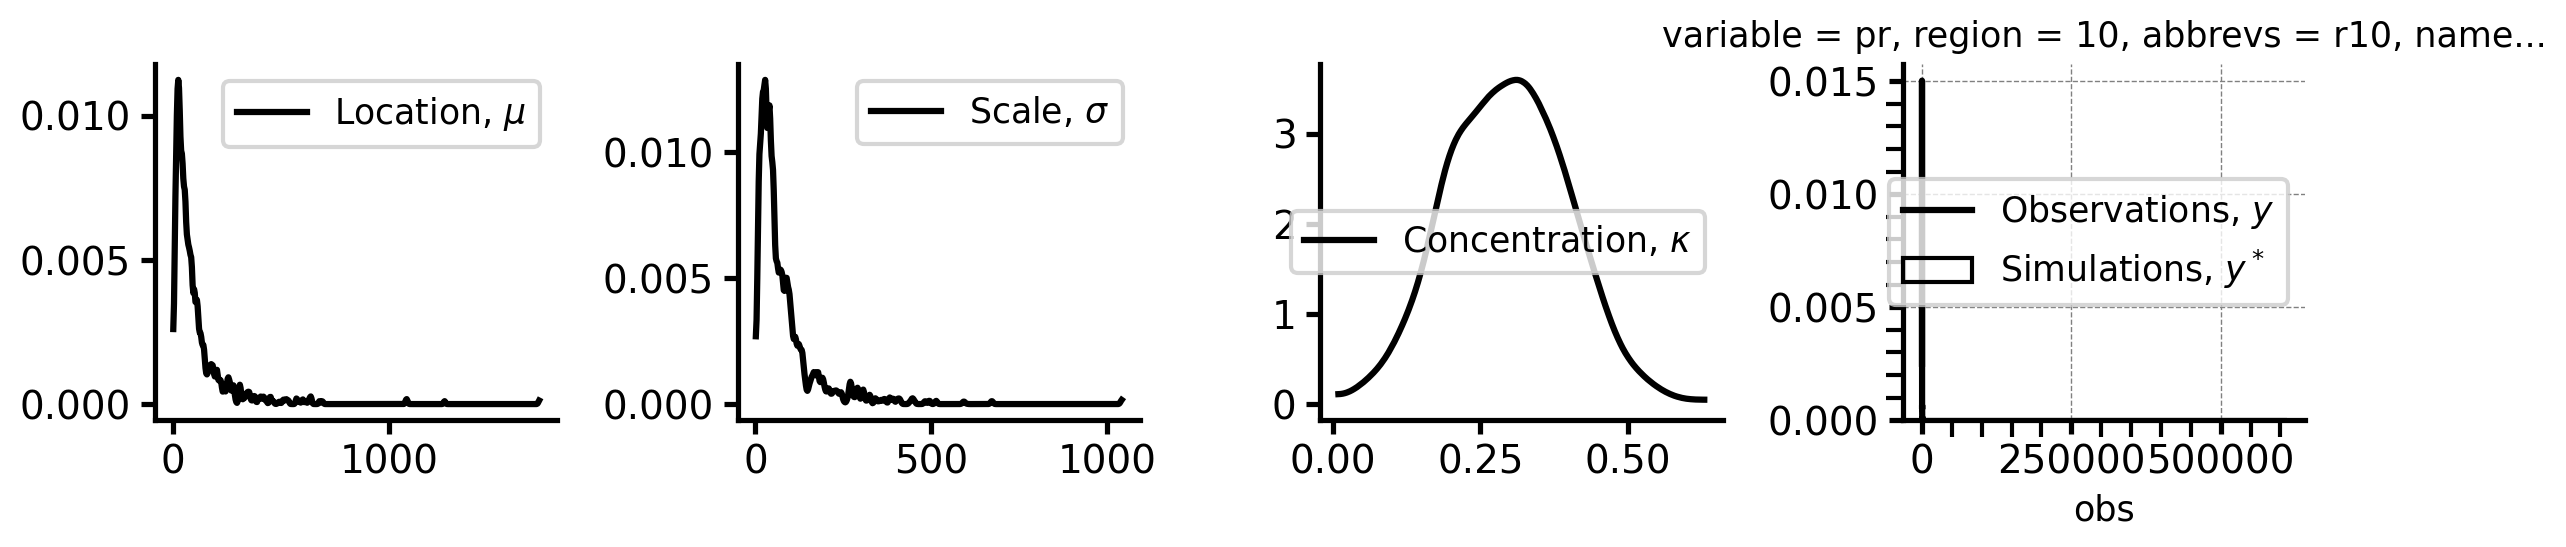

In [90]:
fig, ax = plt.subplots(ncols=4, figsize=(12,3))

az.plot_dist(idata.location, kind="kde", color="black", label=r"Location, $\mu$", ax=ax[0])
az.plot_dist(idata.scale, kind="kde", color="black", label=r"Scale, $\sigma$", ax=ax[1])
az.plot_dist(idata.concentration, kind="kde", color="black", label=r"Concentration, $\kappa$", ax=ax[2])
az.plot_dist(ds_bm_variables_train.sel(variable="pr"), kind="kde", color="black", label=r"Observations, $y$", ax=ax[3])
idata.obs.sel(variable="pr").plot.hist(ax=ax[3], bins=20, density=True, fill=False, color="black", label=r"Simulations, $y^*$")

plt.grid(True, linestyle='--', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.legend()
plt.tight_layout()
fig.set(dpi=100)
plt.show()

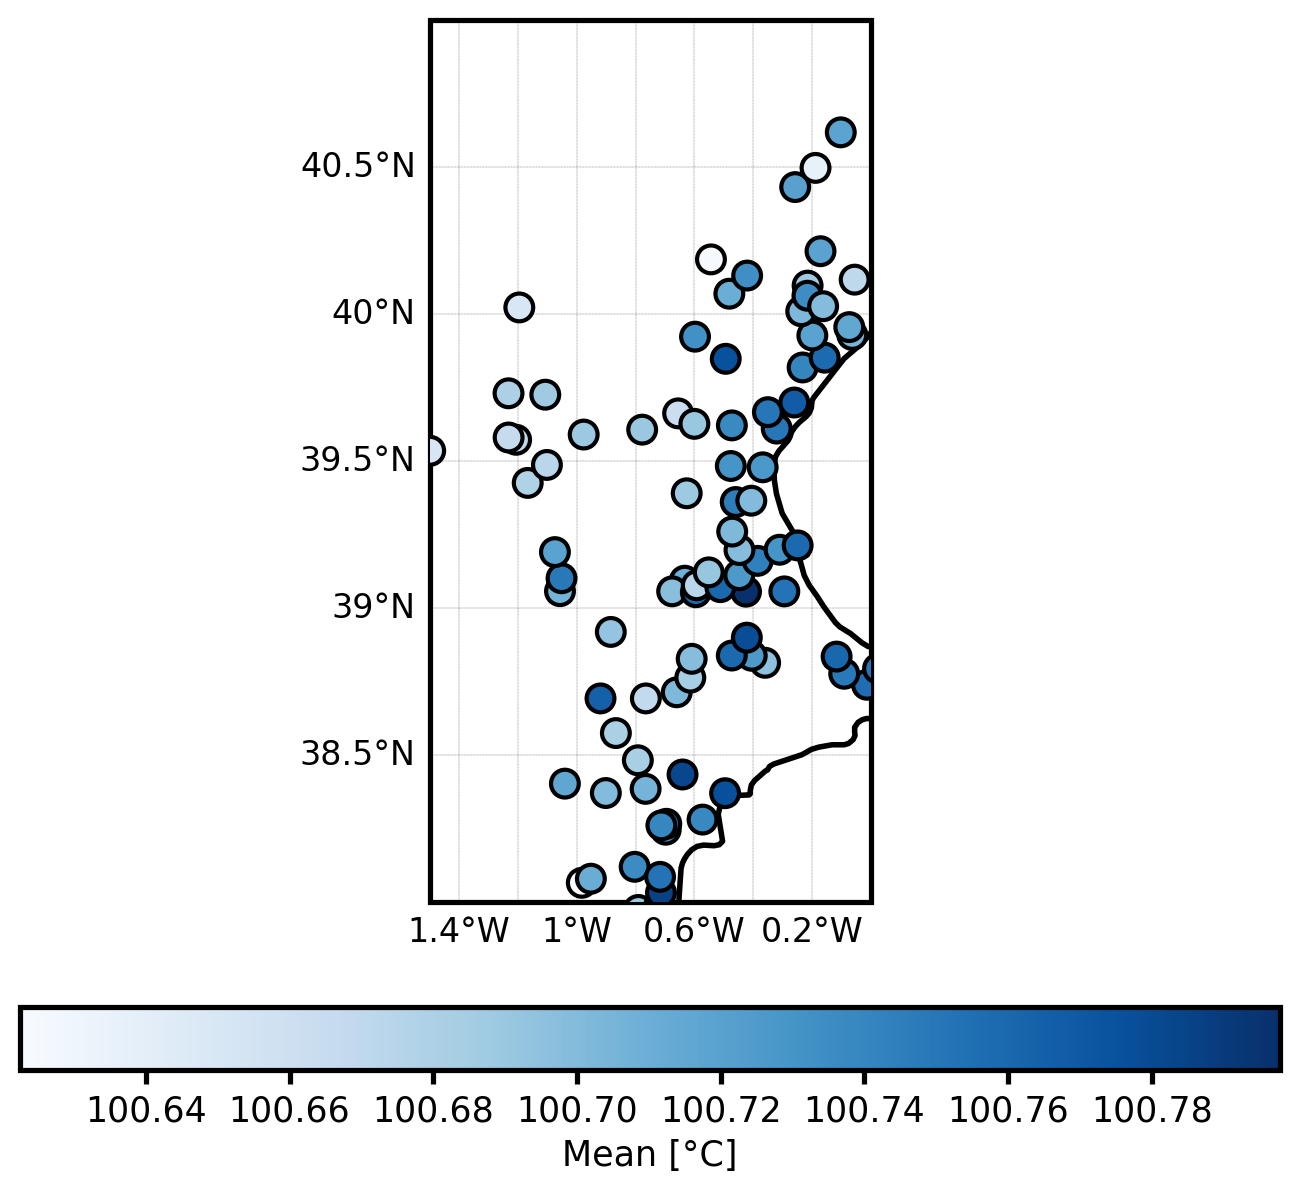

In [91]:
values = az_ds_prior.prior.location.mean(dim=["chain", "draw"]).sel(variable="pr")


fig, ax, cbar = plot_spain(values, cmap="Blues")
extent = [-1.5, 0.0, 38, 41] 

ax.set_extent(extent)
cbar.set_label("Mean [°C]")
fig.set(dpi=100)
plt.show()

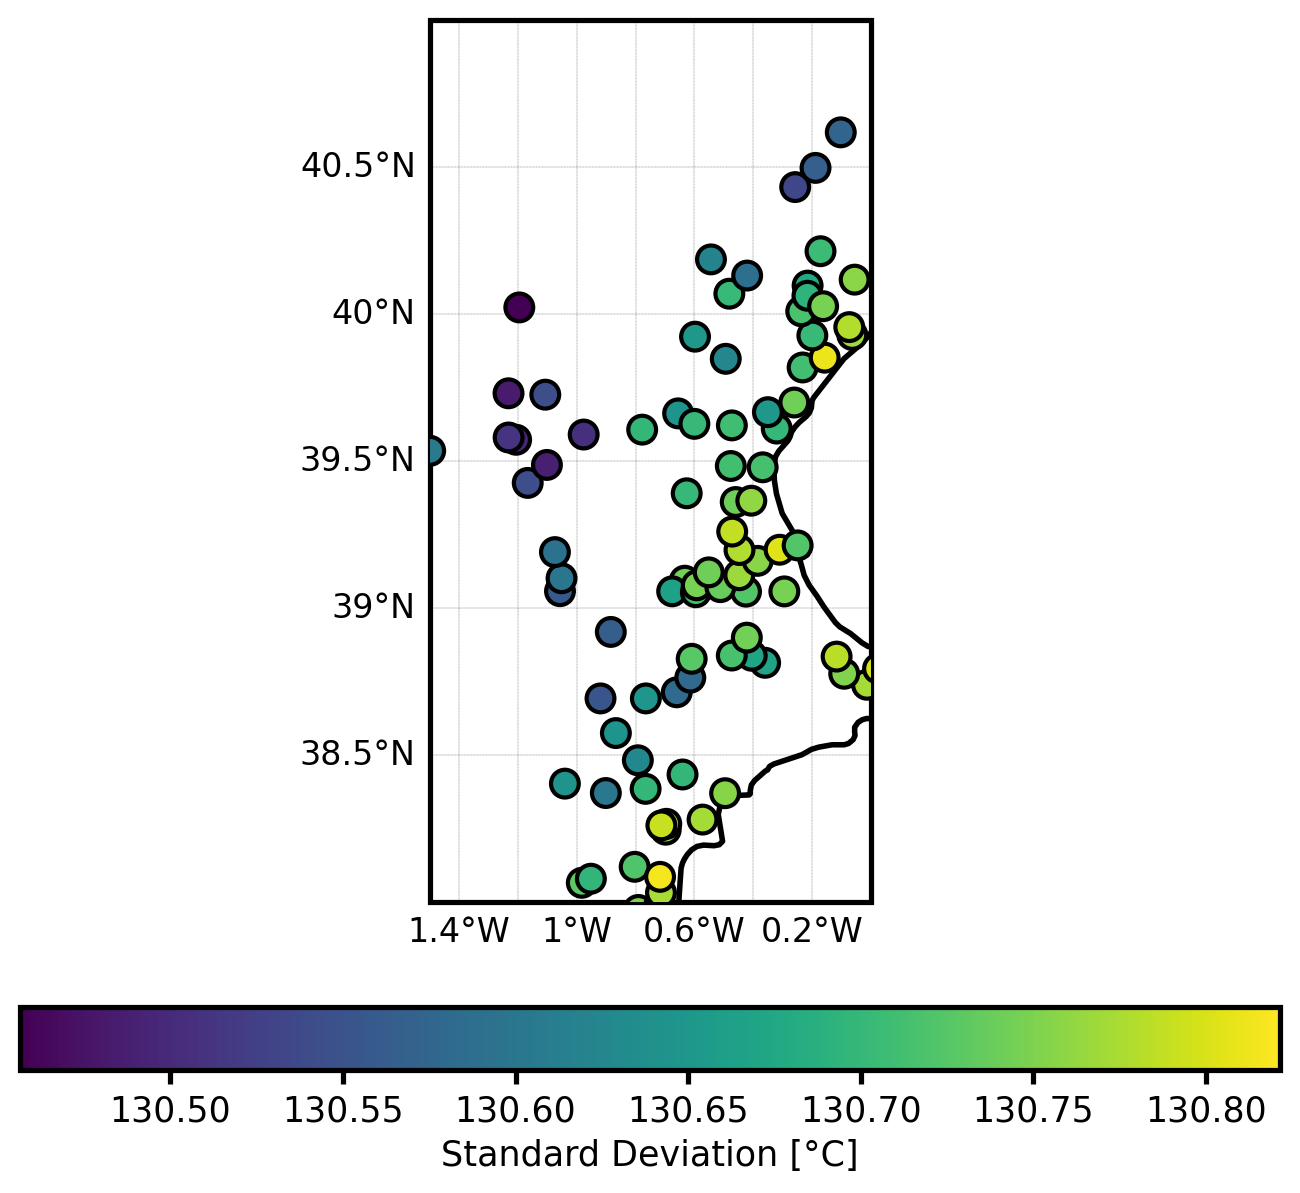

In [92]:
values = az_ds_prior.prior.location.std(dim=["chain", "draw"]).sel(variable="pr")


fig, ax, cbar = plot_spain(values, cmap="viridis")
extent = [-1.5, 0.0, 38, 41] 

ax.set_extent(extent)
cbar.set_label("Standard Deviation [°C]")
fig.set(dpi=100)
plt.show()

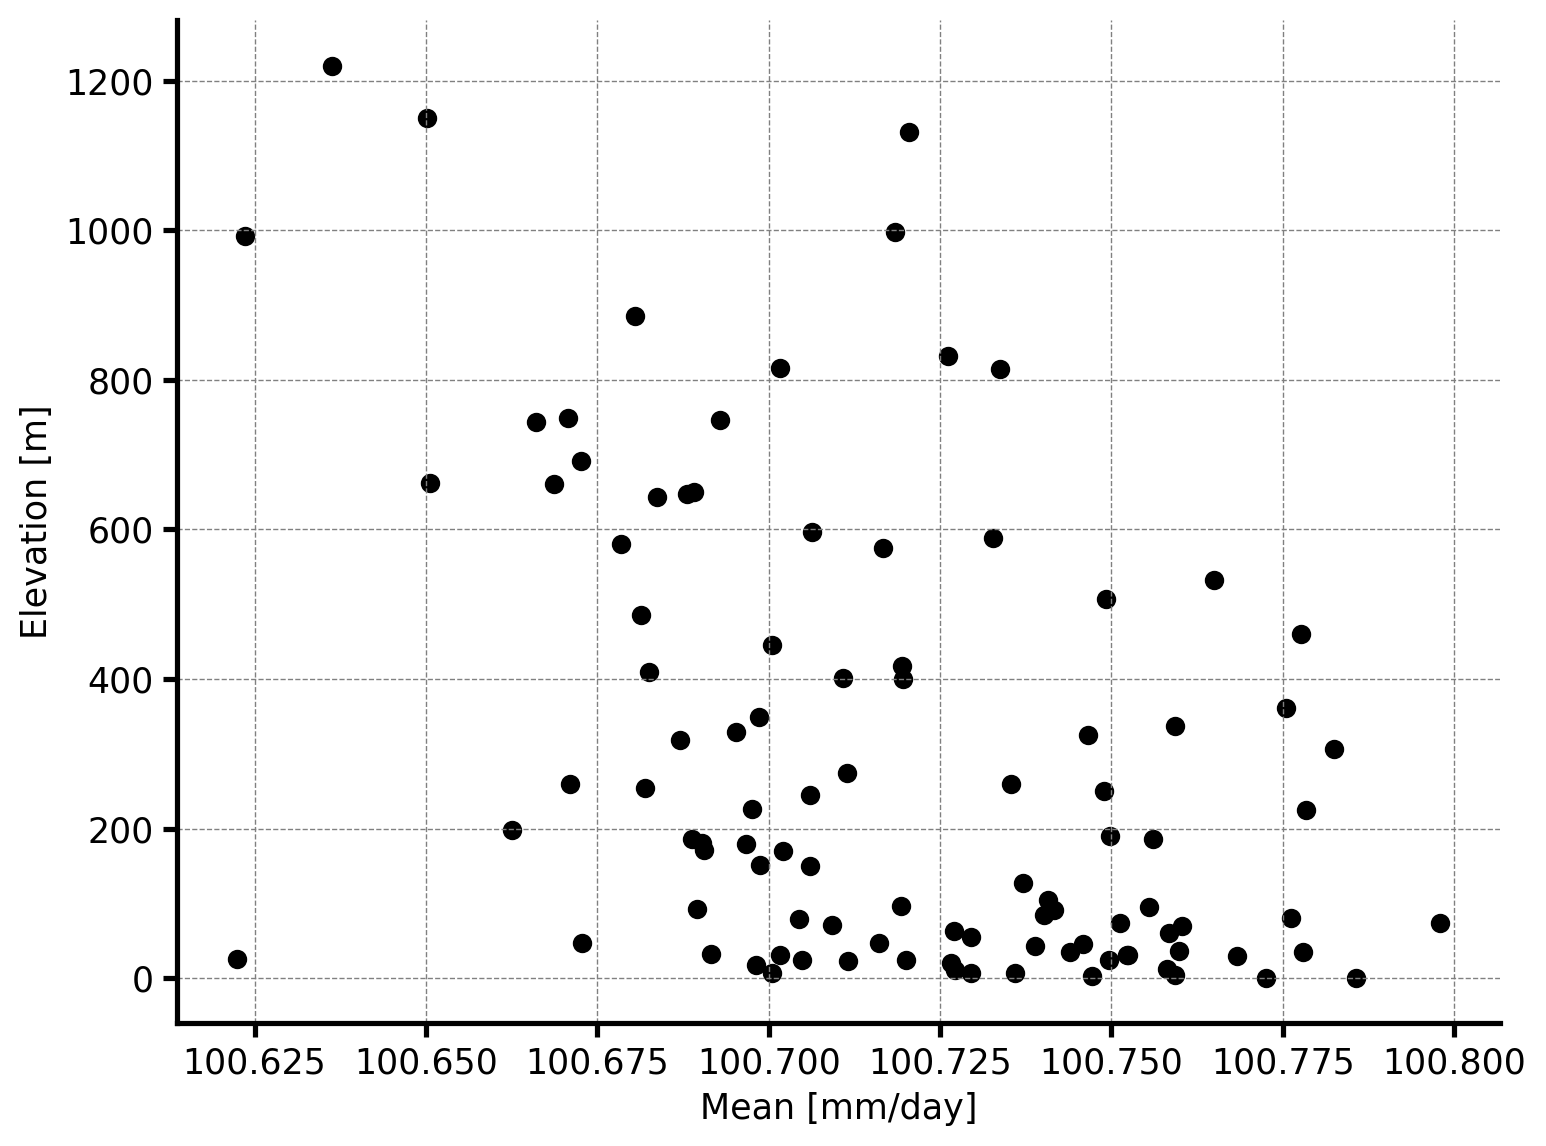

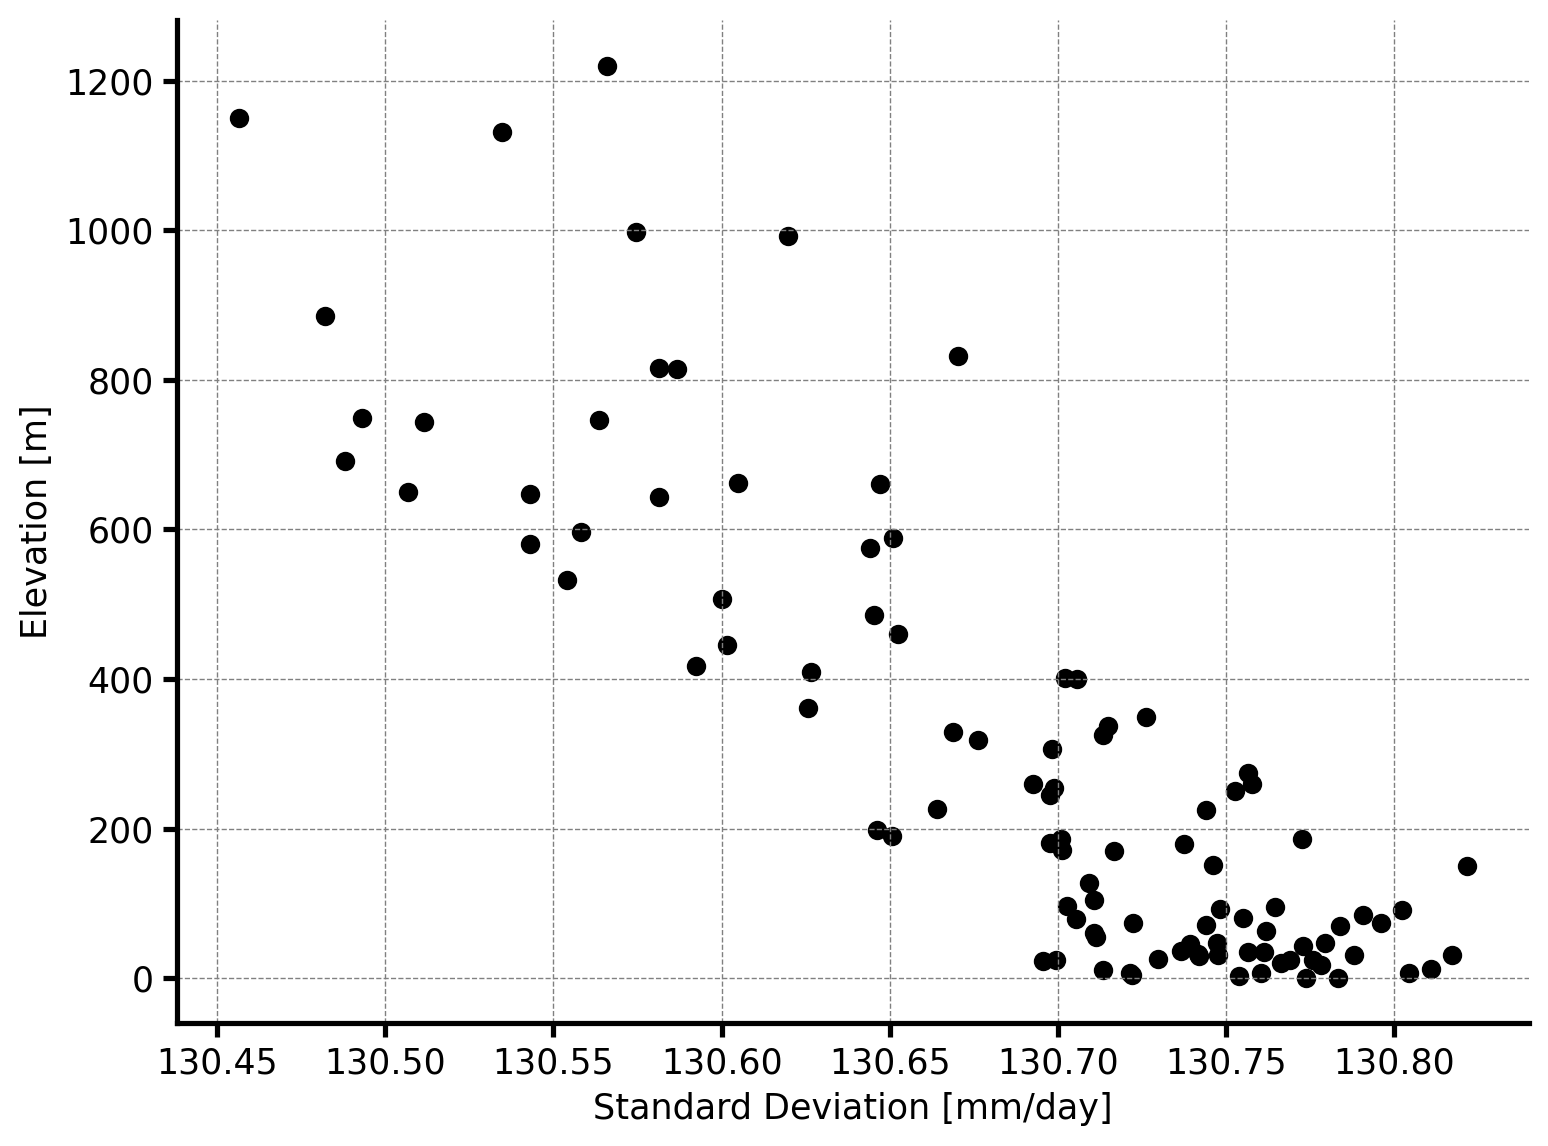

In [93]:
fig, ax = plt.subplots()

values = az_ds_prior.prior.location.sel(variable="pr")

ax.scatter(
    values.mean(dim=["chain", "draw"]),
    az_ds_prior.prior.alt,
    s=30,
    color="black",
    label="Measurements",
)
ax.set(
    xlabel="Mean [mm/day]",
    ylabel="Elevation [m]"
)
plt.grid(True, which="both", linestyle='--', linewidth='0.5', color='gray')
plt.tight_layout()
fig.set(dpi=100)
plt.show()

fig, ax = plt.subplots()
ax.scatter(
    values.std(dim=["chain", "draw"]),
    az_ds_prior.prior.alt,
    s=30,
    color="black",
    label="Measurements",
)
ax.set(
    xlabel="Standard Deviation [mm/day]",
    ylabel="Elevation [m]"
)
plt.grid(True, which="both", linestyle='--', linewidth='0.5', color='gray')
plt.tight_layout()
fig.set(dpi=100)
plt.show()

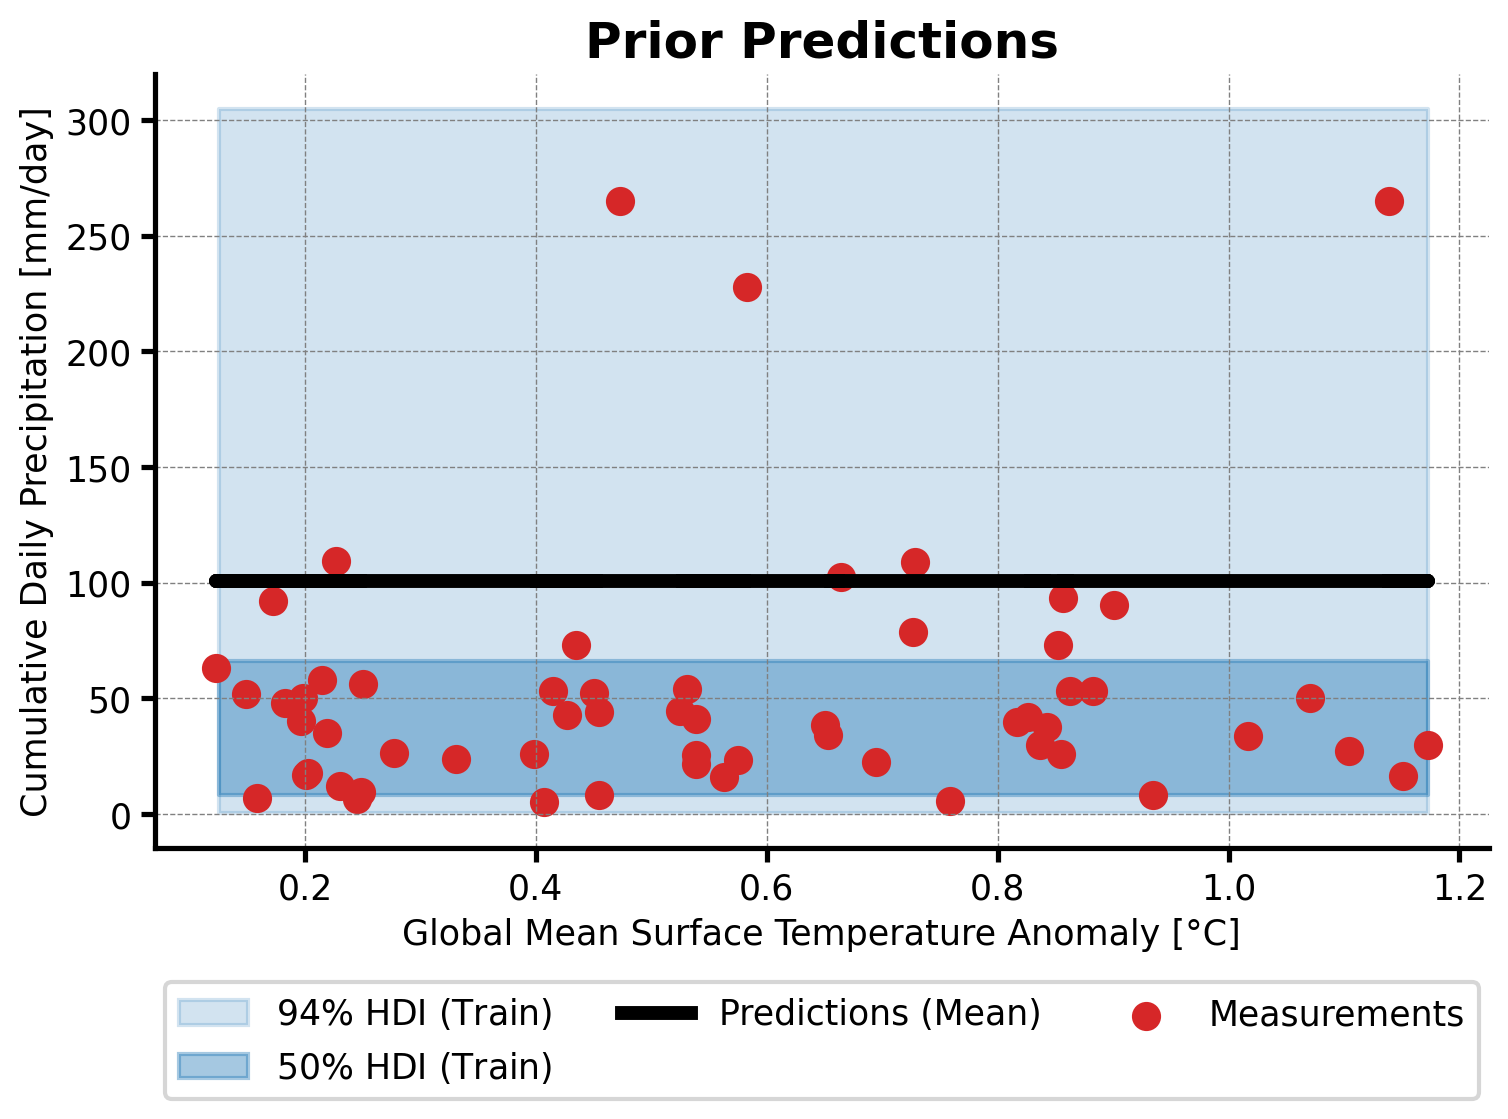

In [94]:
fig, ax = plt.subplots()
gmst = ds_bm["gmst"]
# values = az_ds_prior.prior.location.sel(variable="t2max", station_id="3129A").isel(station_id=0)
values = az_ds_prior.prior.location.sel(variable="pr").isel(station_id=0)
values = values.expand_dims({"gmst": gmst.values}).transpose("chain", "draw", "gmst")
obs = ds_bm_variables_test.sel(variable="pr",).isel(station_id=0)


az.plot_hdi(
    gmst,
    values,
    color="tab:blue",
    smooth=True,
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI (Train)"},
    ax=ax,
)

az.plot_hdi(
    gmst,
    values,
    hdi_prob=0.5,
    color="tab:blue",
    smooth=True,
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI (Train)"},
    ax=ax,
)


mu = az_ds_prior.prior.obs.sel(variable="pr").squeeze().mean(axis=0)

ax.plot(
    gmst,
    values.mean(dim=["chain", "draw"]),
    linewidth=5,
    color="black",
    label="Predictions (Mean)"
)

ax.scatter(
    gmst,
    obs,
    color="tab:red", label="Measurements")
ax.set(
    xlabel="Global Mean Surface Temperature Anomaly [°C]",
    ylabel="Cumulative Daily Precipitation [mm/day]"
)
plt.grid(True, linestyle='--', linewidth='0.5', color='gray')
ax.set_title("Prior Predictions", fontsize=18, fontweight="bold");
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
fig.set(dpi=100)
plt.show()

$$
\begin{aligned}
\boldsymbol{\mu}(\mathbf{s},t) &=
\boldsymbol{\mu}_1(\mathbf{s}) +
\boldsymbol{\mu}_2(\mathbf{s}) x(t)\\
\end{aligned}
$$

#### Intercept Term

**Intercept Term**

$$
\begin{aligned}
\text{Spatial Intercept}: && &&
\boldsymbol{\mu}_1 
&: \mathbb{R}^{D_s} \rightarrow \mathbb{R}^{D_y}
\end{aligned}
$$

**Weights Term**

$$
\begin{aligned}
\text{Spatial Slope}: && &&
\boldsymbol{\mu}_2 
&: \mathbb{R}^{D_s} \rightarrow \mathbb{R}^{D_x \times D_y}\\
\text{Covariate}: && &&
\boldsymbol{x}
&: \mathbb{R}^{+} \rightarrow \mathbb{R}^{D_x}\\
\end{aligned}
$$

$$
\begin{aligned}
\boldsymbol{\sigma}(\mathbf{s},t) &=
\boldsymbol{\sigma}_1(\mathbf{s})\\
\end{aligned}
$$

$$
\begin{aligned}
\boldsymbol{\kappa}(\mathbf{s},t) &=
\kappa_0\\
\end{aligned}
$$

In [ ]:
from st_evt._src.models.inference import SVILearner

num_steps = 25_000
num_warmup_steps = int(0.1 * num_steps)
include_noise = True

init_lr = 1e-10
peak_lr = 1e-3
end_lr = 1e-4
method = "laplace"
svi_learner = SVILearner(numpyro_model, peak_lr=peak_lr, end_lr=end_lr, init_lr=init_lr, num_steps=num_steps, num_warmup_steps=num_warmup_steps, method=method)

svi_posterior = svi_learner(s=s_train, x=x_train, y=y_train, train=True)

  5%|███████████▏                                                                                                                                                                                                                           | 1206/25000 [00:12<03:41, 107.31it/s]

### Loss Function

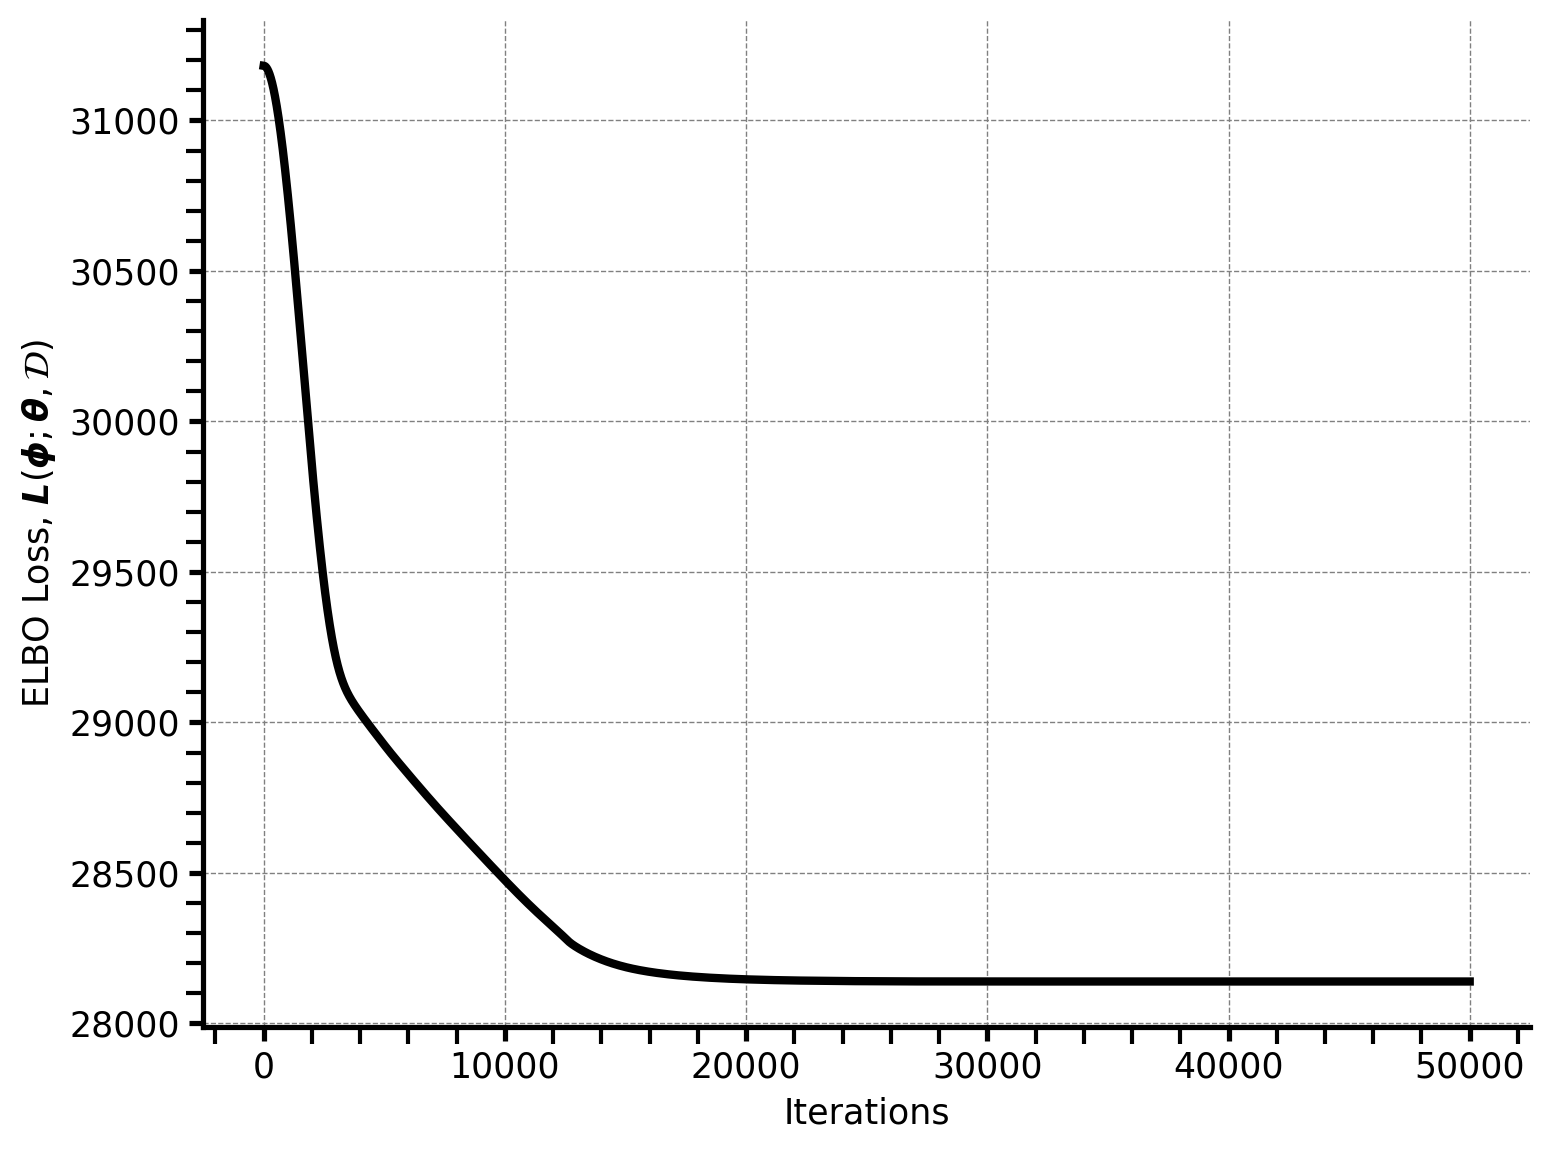

In [117]:
fig, ax = plt.subplots()

# ax.plot(svi_post.svi_result.losses, linewidth=3, color="black")
ax.plot(svi_posterior.svi_result.losses, linewidth=3, color="black")
ax.set(
    xlabel="Iterations",
    ylabel=r"ELBO Loss, $\boldsymbol{L}(\boldsymbol{\phi};\boldsymbol{\theta},\mathcal{D})$",
    # yscale="log"
)
plt.grid(True, linestyle='--', linewidth='0.5', color='gray')
plt.minorticks_on()
fig.set(dpi=100)
plt.show()

## Posterior

#### Posterior Samples

$$
\begin{aligned}
\text{Parameters}: && &&
\boldsymbol{\theta}^* &=
q(\mathbf{\theta};\boldsymbol{\phi})\\
\text{Latent Variables}: && &&
\mathbf{z}^* &=
q(\mathbf{z};\boldsymbol{\phi})\\
\end{aligned}
$$

In [118]:
logger.info("Generating Posterior Samples...")
include_noise = True
num_posterior_samples = 1_000

# POSTERIOR
rng_key, rng_subkey = jrandom.split(rng_key)
posterior_samples = svi_posterior.variational_samples(rng_subkey, num_samples=num_posterior_samples)

2025-01-09 19:29:22.142 | INFO     | __main__:<module>:1 - Generating Posterior Samples...


In [119]:
list(map(lambda k: print(f"{k[0]}: {k[1].shape}"), posterior_samples.items()));

concentration: (1000,)
location: (1000, 100, 1)
location_field_cond: (1000, 1, 100)
location_kernel_scale: (1000, 3)
location_kernel_variance: (1000,)
location_mean: (1000, 100, 1)
location_mean_intercept: (1000, 1)
location_mean_slope: (1000, 3, 1)
location_noise: (1000,)
scale: (1000, 100, 1)
scale_field_cond: (1000, 1, 100)
scale_kernel_scale: (1000, 3)
scale_kernel_variance: (1000,)
scale_mean: (1000, 100, 1)
scale_mean_intercept: (1000, 1)
scale_mean_slope: (1000, 3, 1)
scale_noise: (1000,)


#### Log-Likelihood

In [120]:
# LOG LIKELIHOOD (Posterior)
logger.info("Calculating Log-Likelihood...")
nll_post_samples = svi_posterior.log_likelihood_samples(
    rng_subkey,
    num_samples=num_posterior_samples,
    parallel=False,
    # MY MODEL ARGUMENTS
    s=s_train,
    x=x_train,
    y=y_train,
    train=True,
)

2025-01-09 19:29:31.472 | INFO     | __main__:<module>:2 - Calculating Log-Likelihood...


In [121]:
logger.info("Constructing Posterior...")
az_ds = az.from_dict(
    posterior={k: np.expand_dims(v, 0) for k, v in posterior_samples.items()},
    log_likelihood={k: np.expand_dims(v, 0) for k, v in nll_post_samples.items()},
    observed_data={"obs": y_train},
    dims=model.dimensions,
)

# correct coordinates
logger.info("Correcting Coordinates...")
az_ds = az_ds.assign_coords({"variable":  variables})
az_ds = az_ds.assign_coords({SPATIAL_DIM_NAME:  ds_bm_coords_train[SPATIAL_DIM_NAME]})
az_ds = az_ds.assign_coords({SPATIAL_COORDS_DIM_NAME:  ds_bm_coords_train[SPATIAL_COORDS_DIM_NAME]})
az_ds = az_ds.assign_coords({"time":  ds_bm_variables_train.time})
az_ds.posterior = xr.merge([az_ds.posterior, ds_bm[covariates]])

az_ds.observed_data["gmst"] = ds_bm["gmst"]

# fix some log likelihood stats
logger.info("Fixing Log-Likelihood Stats...")
nll = az_ds.log_likelihood["obs"]
az_ds.log_likelihood["obs"] = nll.where(np.isfinite(nll), np.finfo(float).eps)

# add extra data
logger.info("Adding Extra Information...")

az_ds

2025-01-09 19:29:33.680 | INFO     | __main__:<module>:1 - Constructing Posterior...
2025-01-09 19:29:33.693 | INFO     | __main__:<module>:10 - Correcting Coordinates...
2025-01-09 19:29:33.745 | INFO     | __main__:<module>:20 - Fixing Log-Likelihood Stats...
2025-01-09 19:29:33.758 | INFO     | __main__:<module>:25 - Adding Extra Information...


Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data

#### MCMC Statistics

In [122]:
stats = az.waic(az_ds)
stats

Computed from 1000 posterior samples and 5900 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -29012.10    81.08
p_waic        7.45        -

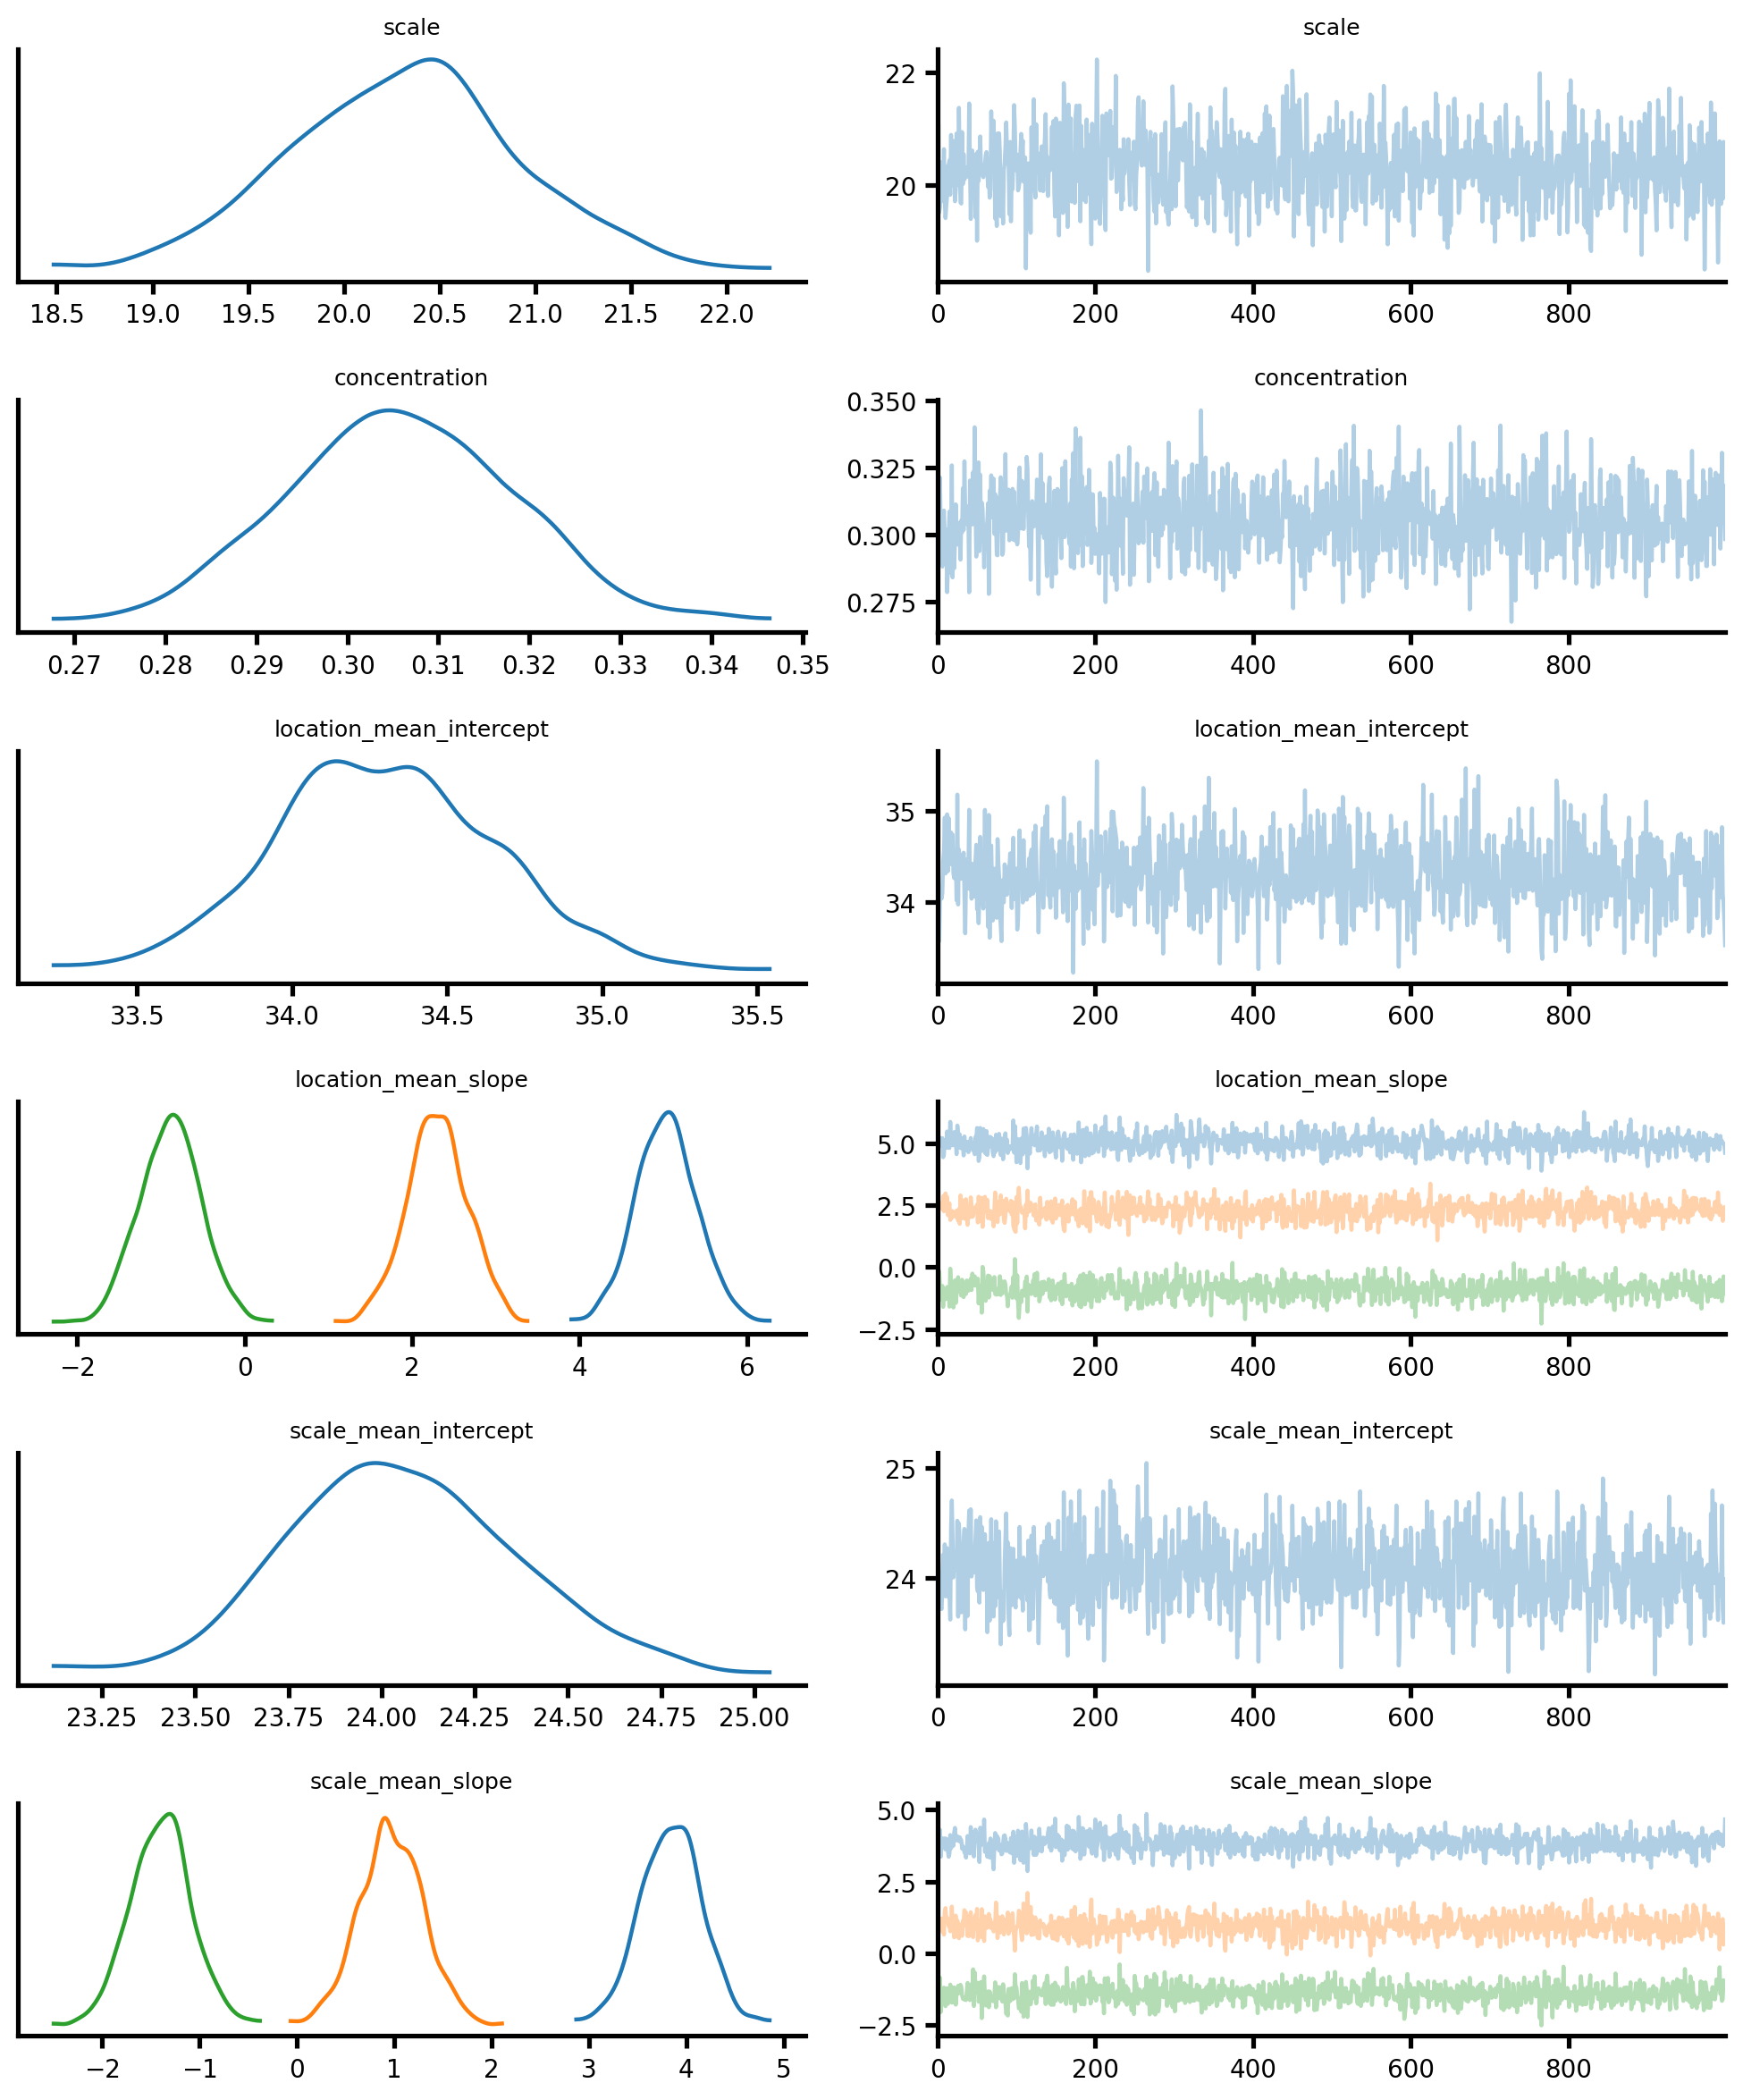

In [123]:
var_names = [
    "scale",
    "concentration",
    "location_mean_intercept",
    "location_mean_slope",
    "scale_mean_intercept",
    "scale_mean_slope",
]

fig = az.plot_trace(
    az_ds.posterior.isel(station_id=0), 
    var_names=var_names,
    figsize=(10, 12)
);
# plt.savefig(figures_path.joinpath("trace.png"))
plt.gcf().set_dpi(100)
plt.show()

### Predictive Posterior

We also want to make predictions at all of the sites and not just the ones we've trained on.

In [124]:
# PREDICTIVE POSTERIOR
return_sites = [
    "location", 
    "location_slope",
    "location_intercept",
    "scale",
    "concentration",
    "obs",

]
posterior_predictive_samples = svi_posterior.posterior_predictive_samples(
    rng_subkey, 
    parallel=False,
    num_samples=num_posterior_samples,
    return_sites=return_sites,
    s=s_test, x=x_train, y=None, train=False, 
)

In [125]:
list(map(lambda k: print(f"{k[0]}: {k[1].shape}"), posterior_predictive_samples.items()));

concentration: (1000,)
location: (1000, 100, 1)
obs: (1000, 59, 100, 1)
scale: (1000, 100, 1)


#### Log-Likelihood

We can also take the log-likelihood of these samples because we have access to the observations at every station.
We need to change this by plugging into the predictive posterior for the samples at all of the locations.
Then, we can calculate the log-likelihood of these samples.

In [126]:
# PREDICTIVE POSTERIOR
posterior_predictive_samples_all = svi_posterior.posterior_predictive_samples(
    rng_subkey, 
    parallel=False,
    num_samples=num_posterior_samples,
    return_sites=model.variables,
    s=s_test, x=x_train, train=False, y=None,
)

In [127]:
# list(map(lambda k: print(f"{k[0]}: {k[1].shape}"), posterior_predictive_samples_all.items()));

In [128]:
s_test.shape, y_test.shape

((100, 3), (59, 100, 1))

In [129]:
from numpyro.infer import log_likelihood 


nll_postpred_samples = log_likelihood(
    model=numpyro_model,
    posterior_samples=posterior_predictive_samples_all,
    parallel=False,
    # batch_ndim=1,
    # My Function Arguments
    s=s_test,
    x=x_train,
    y=y_test,
    train=False,
    
)
list(map(lambda k: print(f"{k[0]}: {k[1].shape}"), nll_postpred_samples.items()));

obs: (1000, 59, 100, 1)


In [130]:
posterior_predictive_samples["nll"] = nll_postpred_samples["obs"]

In [131]:
logger.info("Constructing Posterior...")
dimensions = model.dimensions
dimensions["nll"] = model.dimensions["obs"]

az_ds_postpred = az.from_dict(
    posterior_predictive={k: np.expand_dims(v, 0) for k, v in posterior_predictive_samples.items()},
    dims=dimensions,
)

# correct coordinates
logger.info("Correcting Coordinates...")
az_ds_postpred = az_ds_postpred.assign_coords({"variable":  variables})
az_ds_postpred = az_ds_postpred.assign_coords({SPATIAL_DIM_NAME:  ds_bm_coords_test[SPATIAL_DIM_NAME]})
az_ds_postpred = az_ds_postpred.assign_coords({SPATIAL_COORDS_DIM_NAME:  ds_bm_coords_test[SPATIAL_COORDS_DIM_NAME]})
az_ds_postpred = az_ds_postpred.assign_coords({"time":  ds_bm_variables_train.time})
# az_ds_postpred = az_ds_postpred.assign_coords({covariate: ds_bm[]})

# # fix some log likelihood stats
# logger.info("Fixing Log-Likelihood Stats...")
nll = az_ds_postpred.posterior_predictive["obs"]
az_ds_postpred.posterior_predictive["obs"] = nll.where(np.isfinite(nll), np.finfo(float).eps)

az_ds_postpred

2025-01-09 19:29:54.422 | INFO     | __main__:<module>:1 - Constructing Posterior...
2025-01-09 19:29:54.593 | INFO     | __main__:<module>:11 - Correcting Coordinates...


Inference data with groups:
	> posterior_predictive

### Combined Datastructure

In [132]:
az_ds.add_groups(az_ds_postpred)
az_ds

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

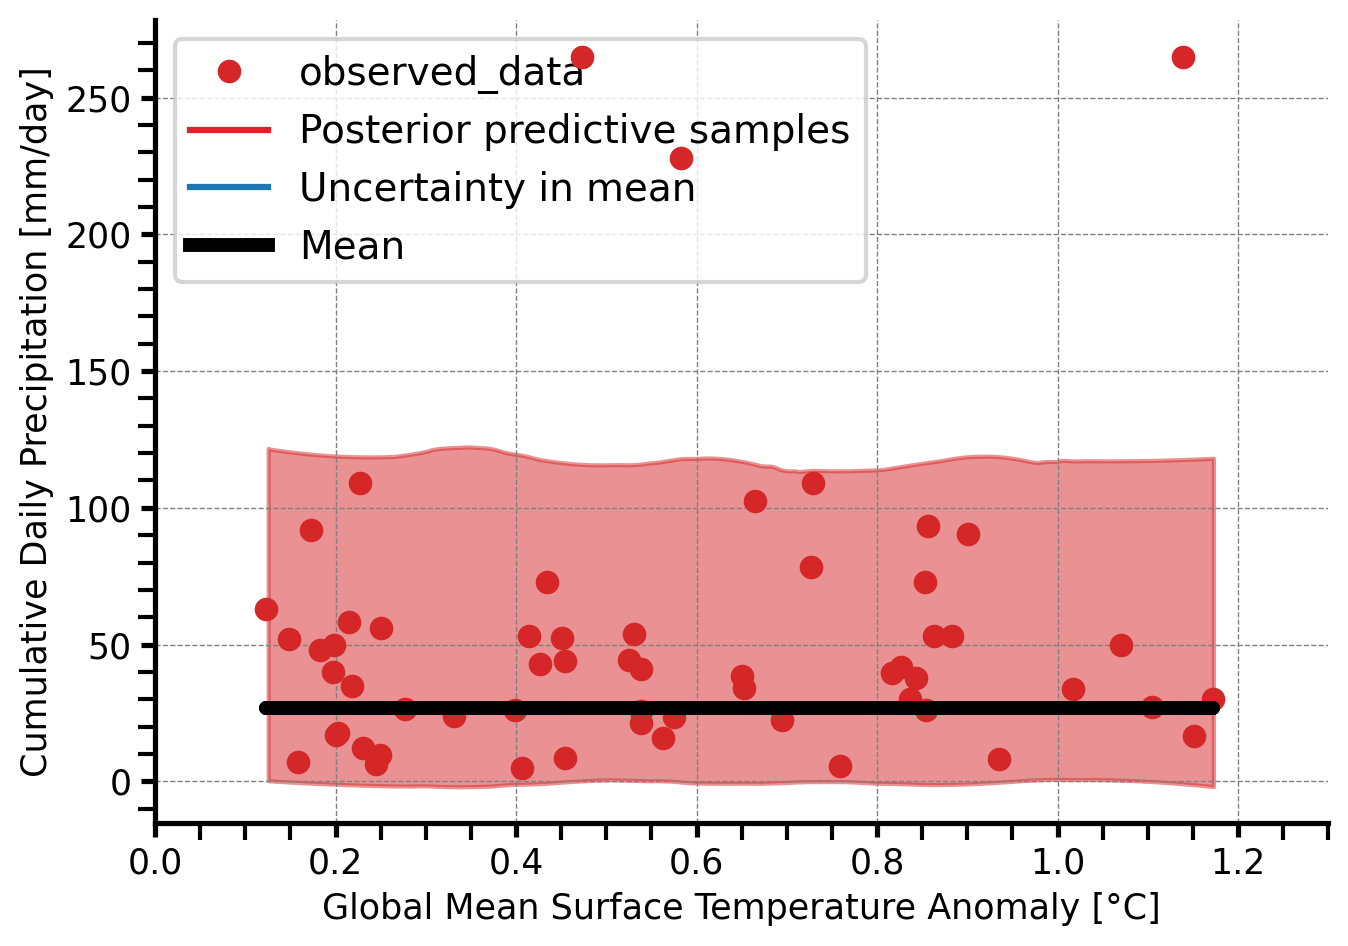

In [133]:
# X-VARIABLE
demo = az_ds.isel(station_id=0)
x = ds_bm.gmst

# Y-Observations
y = demo.observed_data.obs.sel(variable="pr")

# POSTERIOR SAMPLES
y_hat = demo.posterior_predictive.obs.sel(variable="pr")
y_hat = y_hat.expand_dims({"gmst": gmst.values})#.transpose("chain", "draw", "gmst")


# PREDICTIONS
y_model = demo.posterior_predictive["location"].sel(variable="pr") # az_ds.predictions[variable]
y_model = y_model.expand_dims({"gmst": gmst.values}).transpose("chain", "draw", "gmst")


# INITIALIZE PLOT
fig, ax = plt.subplots()

# PLOT KWARGS
kind_pp = "hdi"
kind_model = "hdi"
y_hat_plot_kwargs = dict(
    color="tab:blue",
    markersize=10.0
)
y_model_mean_kwargs = dict(
    color="black",
    linewidth=5.0,
)

# PLOT
az.plot_lm(
    axes=ax,
    y=y, y_hat=y_hat, x=x, y_model=y_model,
    kind_pp=kind_pp, kind_model=kind_model,
    y_hat_plot_kwargs=y_hat_plot_kwargs,
    y_model_mean_kwargs=y_model_mean_kwargs,
)

ax.set(
    xlabel="Global Mean Surface Temperature Anomaly [°C]",
    ylabel="Cumulative Daily Precipitation [mm/day]",
    xlim=[0.0, 1.3]
)
plt.grid(True, linestyle='--', linewidth='0.5', color='gray')
plt.minorticks_on()
fig.set(
    dpi=100,
    size_inches=(7,5)
)
# plt.savefig(figures_path.joinpath("regression_posterior_samples.png"))
plt.tight_layout()
plt.show()

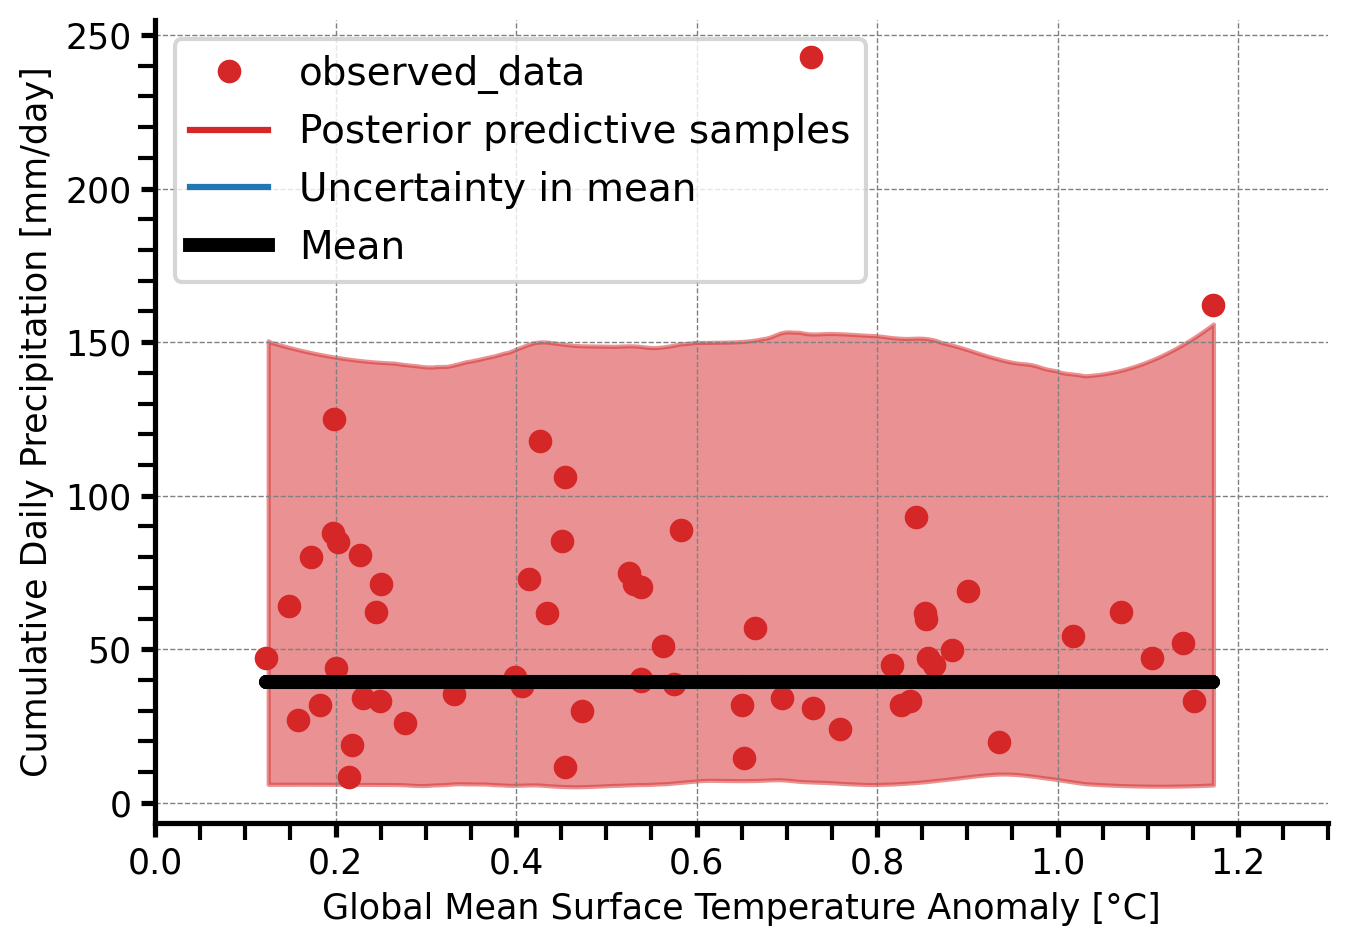

In [134]:
# X-VARIABLE
demo = az_ds.isel(station_id=-1)
x = ds_bm.gmst

# Y-Observations
y = demo.observed_data.obs.sel(variable="pr")

# POSTERIOR SAMPLES
y_hat = demo.posterior_predictive.obs.sel(variable="pr")
y_hat = y_hat.expand_dims({"gmst": gmst.values})#.transpose("chain", "draw", "gmst")


# PREDICTIONS
y_model = demo.posterior_predictive["location"].sel(variable="pr") # az_ds.predictions[variable]
y_model = y_model.expand_dims({"gmst": gmst.values}).transpose("chain", "draw", "gmst")


# INITIALIZE PLOT
fig, ax = plt.subplots()

# PLOT KWARGS
kind_pp = "hdi"
kind_model = "hdi"
y_hat_plot_kwargs = dict(
    color="tab:blue",
    markersize=10.0
)
y_model_mean_kwargs = dict(
    color="black",
    linewidth=5.0,
)

# PLOT
az.plot_lm(
    axes=ax,
    y=y, y_hat=y_hat, x=x, y_model=y_model,
    kind_pp=kind_pp, kind_model=kind_model,
    y_hat_plot_kwargs=y_hat_plot_kwargs,
    y_model_mean_kwargs=y_model_mean_kwargs,
)

ax.set(
    xlabel="Global Mean Surface Temperature Anomaly [°C]",
    ylabel="Cumulative Daily Precipitation [mm/day]",
    xlim=[0.0, 1.3]
)
plt.grid(True, linestyle='--', linewidth='0.5', color='gray')
plt.minorticks_on()
fig.set(
    dpi=100,
    size_inches=(7,5)
)
# plt.savefig(figures_path.joinpath("regression_posterior_samples.png"))
plt.tight_layout()
plt.show()

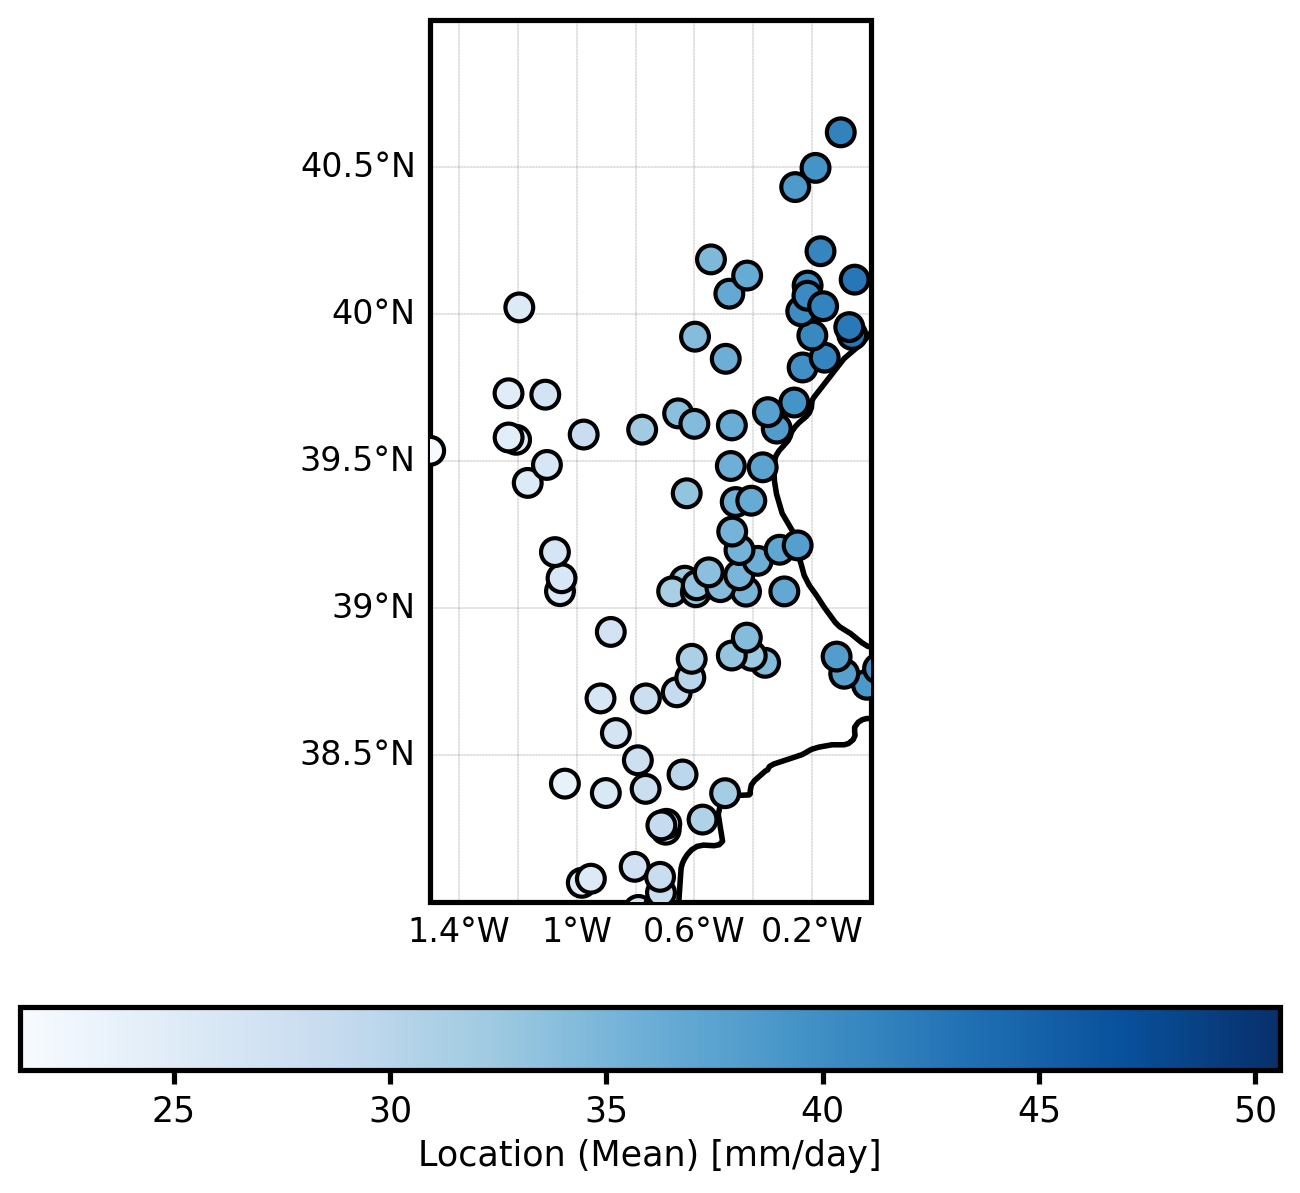

In [136]:
values = az_ds.posterior.location.mean(dim=["chain", "draw"]).sel(variable="pr")


fig, ax, cbar = plot_spain(values, cmap="Blues",)
# extent = [-1.6, 0.0, 38, 40] 

ax.set_extent(extent)
cbar.set_label("Location (Mean) [mm/day]")
fig.set(dpi=100)
plt.show()

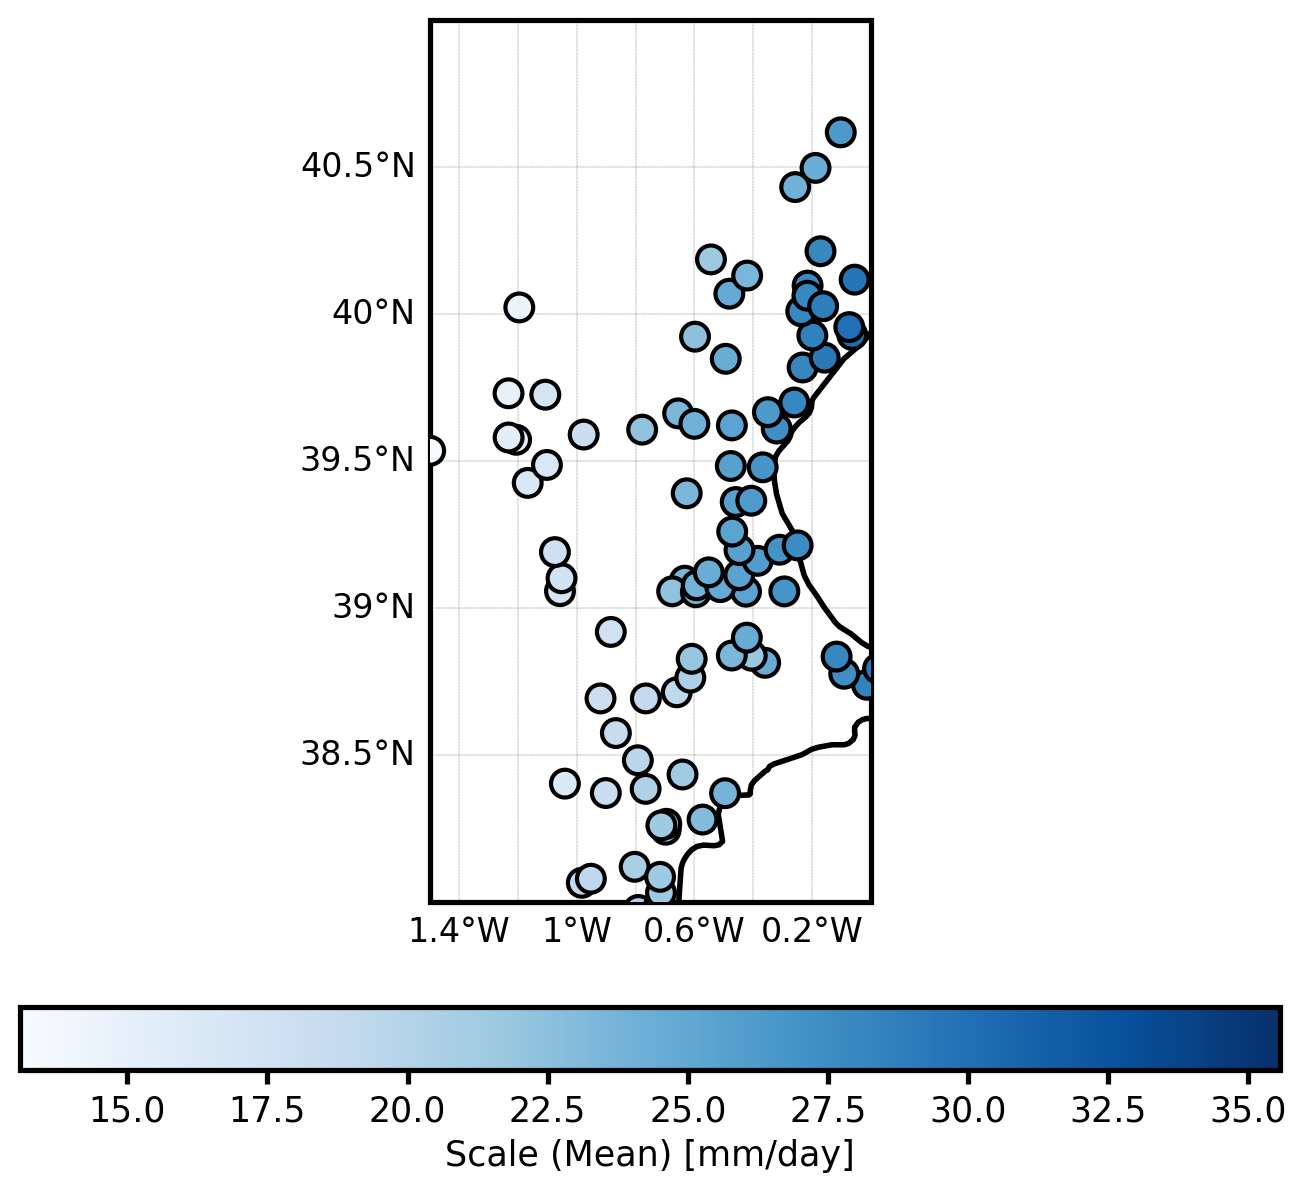

In [137]:
values = az_ds.posterior.scale.mean(dim=["chain", "draw"]).sel(variable="pr")


fig, ax, cbar = plot_spain(values, cmap="Blues",)

ax.set_extent(extent)
cbar.set_label("Scale (Mean) [mm/day]")
fig.set(dpi=100)
plt.show()

### Save Data

In [138]:
results_path = Path("/home/juanjohn/pool_projects/scratch/stevt_tutorial/models/stationary_gp_lap_redfeten_pr_vlc/")
results_path.mkdir(parents=True, exist_ok=True)
save_file_name = results_path.joinpath("results.zarr")
az_ds.to_zarr(store=str(save_file_name))
logger.debug(f"Saved File at:\n{save_file_name}")

2025-01-09 19:30:49.479 | DEBUG    | __main__:<module>:5 - Saved File at:
/home/juanjohn/pool_projects/scratch/stevt_tutorial/models/stationary_gp_lap_redfeten_pr_vlc/results.zarr


In [139]:

import joblib
save_file_name = results_path.joinpath("feature_transforms.joblib")
joblib.dump(
    {
        "spatial": spatial_transformer,
        "variable": variable_transformer,
        },
    save_file_name
)
logger.debug(f"Saved File at:\n{save_file_name}")

2025-01-09 19:30:51.110 | DEBUG    | __main__:<module>:10 - Saved File at:
/home/juanjohn/pool_projects/scratch/stevt_tutorial/models/stationary_gp_lap_redfeten_pr_vlc/feature_transforms.joblib


In [140]:
results_path = Path("/home/juanjohn/pool_projects/scratch/stevt_tutorial/models/stationary_gp_lap_redfeten_pr_vlc/")
results_path.mkdir(parents=True, exist_ok=True)
save_file_name = results_path.joinpath("results.nc")
az_ds.to_netcdf(str(save_file_name))
logger.debug(f"Saved File at:\n{save_file_name}")

2025-01-09 19:30:57.997 | DEBUG    | __main__:<module>:5 - Saved File at:
/home/juanjohn/pool_projects/scratch/stevt_tutorial/models/stationary_gp_lap_redfeten_pr_vlc/results.nc
